In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

# visualization, graph
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep', font_scale=1.5)

plt.style.use('ggplot')

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir('/kaggle/input/competitive-data-science-predict-future-sales/'))

from glob import glob
from copy import deepcopy
import random

['items.csv', 'sample_submission.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv', 'test.csv']


### Files
* sales_train.csv - the training set. **Daily historical data from January 2013 to October 2015**.
* test.csv - the test set. You need to **forecast the sales for these shops and products for November 2015**.
* items.csv - supplemental information about **the items/products**.
* item_categories.csv  - supplemental information about **the items categories**.
* shops.csv- supplemental information about **the shops**.

### DATA
* ID - an Id that **represents a (Shop, Item) tuple within the test set**
* shop_id - unique identifier of a shop
* **item_id - unique identifier of a product**
* item_category_id - unique identifier of item category
* **item_cnt_day - number of products sold. You are predicting a monthly amount of this measure**
* **item_price - current price of an item**
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. **January 2013 is 0, February 2013 is 1,..., October 2015 is 33**
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

# File check

In [2]:
train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv') # parse_dates=["date"]
train_df.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

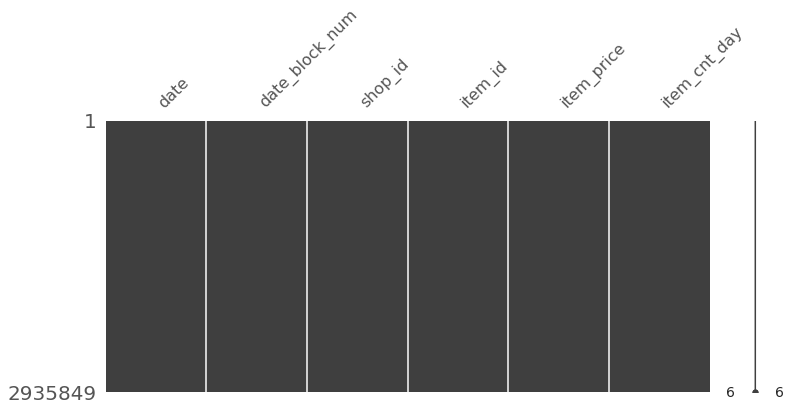

In [5]:
import missingno as msno

msno.matrix(train_df, figsize=(12,5))

In [6]:
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [8]:
test_df.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [9]:
print('shops', set(test_df['shop_id']), sep='\n')
# print('items', set(test_df['item_id']), sep='\n')

shops
{2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59}


In [10]:
sub = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


* **각 shop들에 대해 물품별로 11월 판매량 예측.**

* item info

In [11]:
items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [13]:
item_ca_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
item_ca_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
item_ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


* shop info

In [15]:
shops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [16]:
shops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


# Data preprocessing

## add category feature, separate date, item cnt month sum,..

In [17]:
train_df.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


* add item_category_id 

In [18]:
train_df = pd.merge(train_df, items_df, on='item_id', how='left')
del train_df['item_name']
train_df = train_df[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_df.tail()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,55,7409,299.0,1.0
2935845,09.10.2015,33,25,55,7460,299.0,1.0
2935846,14.10.2015,33,25,55,7459,349.0,1.0
2935847,22.10.2015,33,25,57,7440,299.0,1.0
2935848,03.10.2015,33,25,55,7460,299.0,1.0


In [19]:
test_df = pd.merge(test_df, items_df, on='item_id', how='left')
del test_df['item_name']
del test_df['ID']
test_df = test_df[['shop_id', 'item_category_id', 'item_id']]
test_df.tail()

,shop_id,item_category_id,item_id
214195,45,55,18454
214196,45,64,16188
214197,45,55,15757
214198,45,40,19648
214199,45,37,969


* date -> year, month, day

In [20]:
tmp = pd.DataFrame()
tmp['year'] = train_df['date'].agg(lambda x: int(x.split('.')[2]))
tmp['month'] = train_df['date'].agg(lambda x: int(x.split('.')[1]))
tmp['day'] = train_df['date'].agg(lambda x: int(x.split('.')[0]))
train_df2 = pd.concat([tmp, train_df], axis=1)

# train_df2 = train_df.copy()
# train_df2['year'] = train_df2['date'].dt.year
# train_df2['month'] = train_df2['date'].dt.month
# train_df2['day'] = train_df2['date'].dt.day

del train_df2['date']
train_df2.tail()

,year,month,day,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
2935844,2015,10,10,33,25,55,7409,299.0,1.0
2935845,2015,10,9,33,25,55,7460,299.0,1.0
2935846,2015,10,14,33,25,55,7459,349.0,1.0
2935847,2015,10,22,33,25,57,7440,299.0,1.0
2935848,2015,10,3,33,25,55,7460,299.0,1.0


In [21]:
test_df['year'] = 2015
test_df['month'] = 11
test_df['date_block_num'] = max(train_df2['date_block_num'])+1
test_df = test_df[['year', 'month', 'date_block_num', 'shop_id', 'item_category_id', 'item_id']]
test_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id
214195,2015,11,34,45,55,18454
214196,2015,11,34,45,64,16188
214197,2015,11,34,45,55,15757
214198,2015,11,34,45,40,19648
214199,2015,11,34,45,37,969


* train set outlier check
* Q-Q(Quantile-Quantile) plot
> 샘플 플롯과 정규 분포의 분포 형태 비교.
> https://datascienceschool.net/view-notebook/26f1850cd89f419993db0648bbd3c900/

Text(0.5, 1.0, 'item cnt day probability plot')

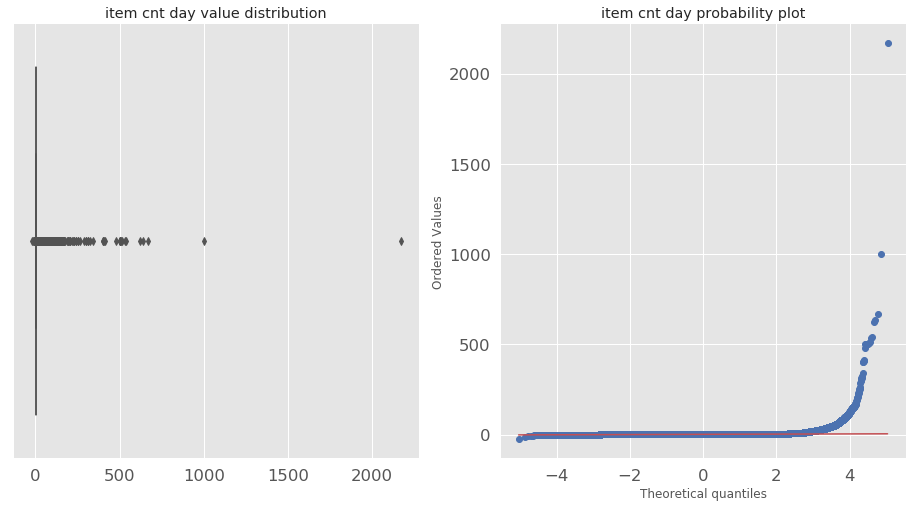

In [22]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df2['item_cnt_day'].values, ax=ax[0])
ax[0].set_title('item cnt day value distribution')
stats.probplot(train_df2['item_cnt_day'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item cnt day probability plot')

Text(0.5, 1.0, 'item cnt day probability plot')

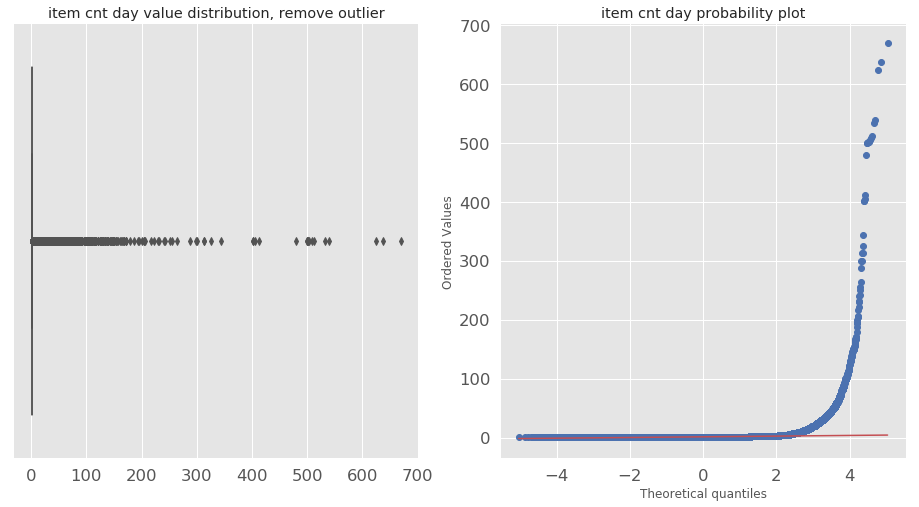

In [23]:
train_df2.drop(train_df2[train_df2['item_cnt_day'] > 800].index, inplace=True)
train_df2.drop(train_df2[train_df2['item_cnt_day'] < 0].index, inplace=True)

fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df2['item_cnt_day'].values, ax=ax[0])
ax[0].set_title('item cnt day value distribution, remove outlier')
stats.probplot(train_df2['item_cnt_day'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item cnt day probability plot')

Text(0.5, 1.0, 'item price probability plot')

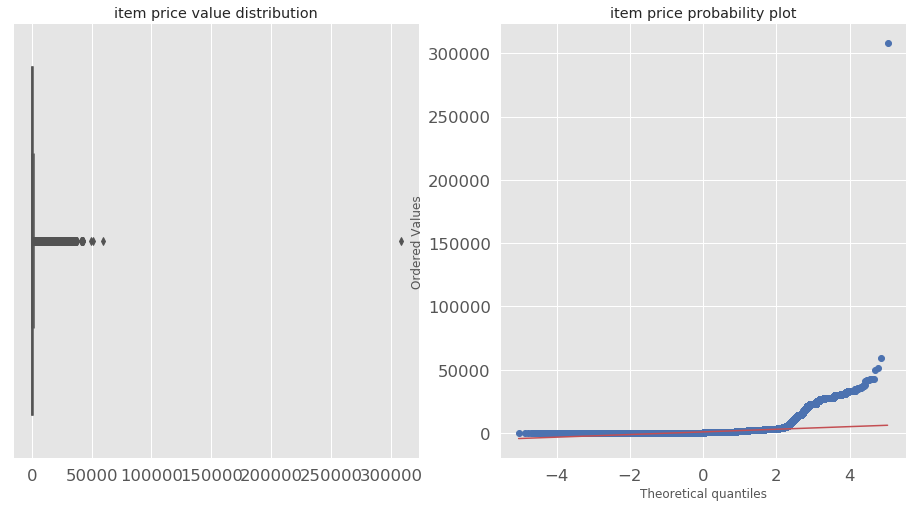

In [24]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df2['item_price'].values, ax=ax[0])
ax[0].set_title('item price value distribution')
stats.probplot(train_df2['item_price'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item price probability plot')

Text(0.5, 1.0, 'item price probability plot')

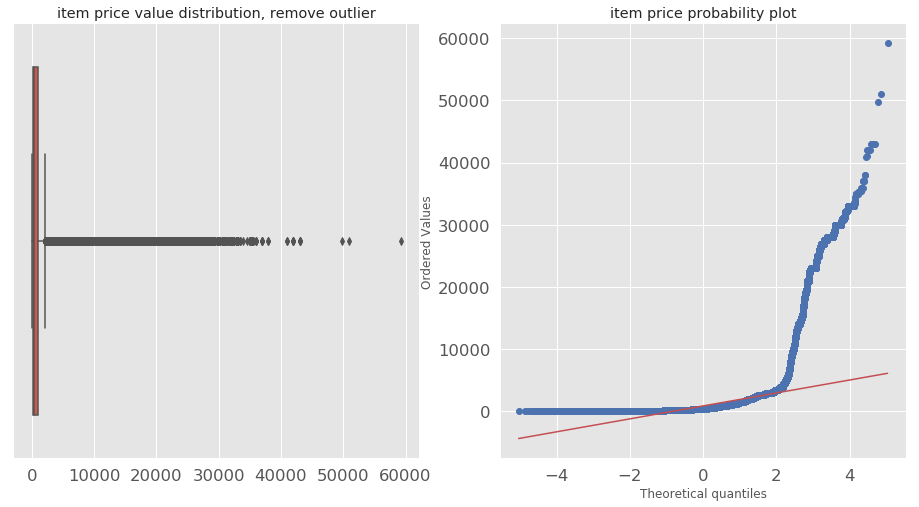

In [25]:
train_df2.drop(train_df2[train_df2['item_price'] > 100000].index, inplace=True)
train_df2.drop(train_df2[train_df2['item_price'] < 0].index, inplace=True)

fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df2['item_price'].values, ax=ax[0])
ax[0].set_title('item price value distribution, remove outlier')
stats.probplot(train_df2['item_price'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item price probability plot')

* item cnt and price value must be normalize

* check duplicates

In [26]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928489 entries, 0 to 2935848
Data columns (total 9 columns):
year                int64
month               int64
day                 int64
date_block_num      int64
shop_id             int64
item_category_id    int64
item_id             int64
item_price          float64
item_cnt_day        float64
dtypes: float64(2), int64(7)
memory usage: 223.4 MB


In [27]:
train_df2 = train_df2.drop_duplicates(['year', 'month', 'day','date_block_num', 'shop_id',
                                       'item_category_id','item_id', 'item_price', 'item_cnt_day'], keep='first')
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928483 entries, 0 to 2935848
Data columns (total 9 columns):
year                int64
month               int64
day                 int64
date_block_num      int64
shop_id             int64
item_category_id    int64
item_id             int64
item_price          float64
item_cnt_day        float64
dtypes: float64(2), int64(7)
memory usage: 223.4 MB


* train set item cnt month sum

In [28]:
train_df3 = pd.DataFrame(train_df2.groupby(['shop_id','item_category_id','item_id','item_price','year','month','date_block_num'])['item_cnt_day'].sum())
train_df3.reset_index(inplace=True)
train_df3.columns = ['shop_id', 'item_category_id', 'item_id', 'item_price', 
                     'year', 'month', 'date_block_num','item_cnt']
train_df3.tail()

,shop_id,item_category_id,item_id,item_price,year,month,date_block_num,item_cnt
1737857,59,83,22092,139.0,2014,12,23,3.0
1737858,59,83,22092,139.0,2015,1,24,2.0
1737859,59,83,22092,159.0,2015,1,24,1.0
1737860,59,83,22092,179.0,2015,3,26,3.0
1737861,59,83,22092,179.0,2015,8,31,1.0


In [29]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737862 entries, 0 to 1737861
Data columns (total 8 columns):
shop_id             int64
item_category_id    int64
item_id             int64
item_price          float64
year                int64
month               int64
date_block_num      int64
item_cnt            float64
dtypes: float64(2), int64(6)
memory usage: 106.1 MB


Text(0.5, 1.0, 'item cnt monthly probability plot')

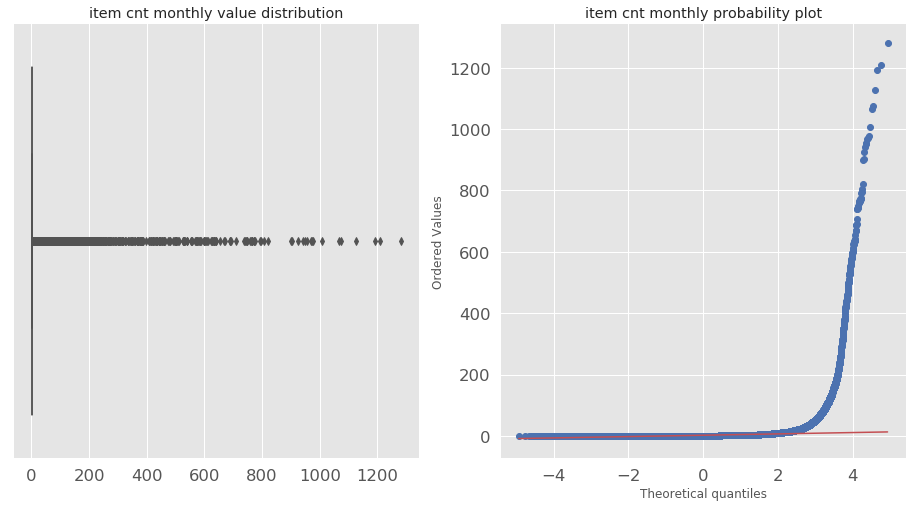

In [30]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df3['item_cnt'].values, ax=ax[0])
ax[0].set_title('item cnt monthly value distribution')
stats.probplot(train_df3['item_cnt'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item cnt monthly probability plot')

* 다른 커널들을 보니 cnt값을 0~20사이로 clipping 시키거나 범위 밖 데이터는 아예 사용하지 않음.
* probability plot에서 알 수 있듯이, 이 범위 밖의 데이터들은 outlier로 간주한다.

Text(0.5, 1.0, 'item cnt monthly probability plot')

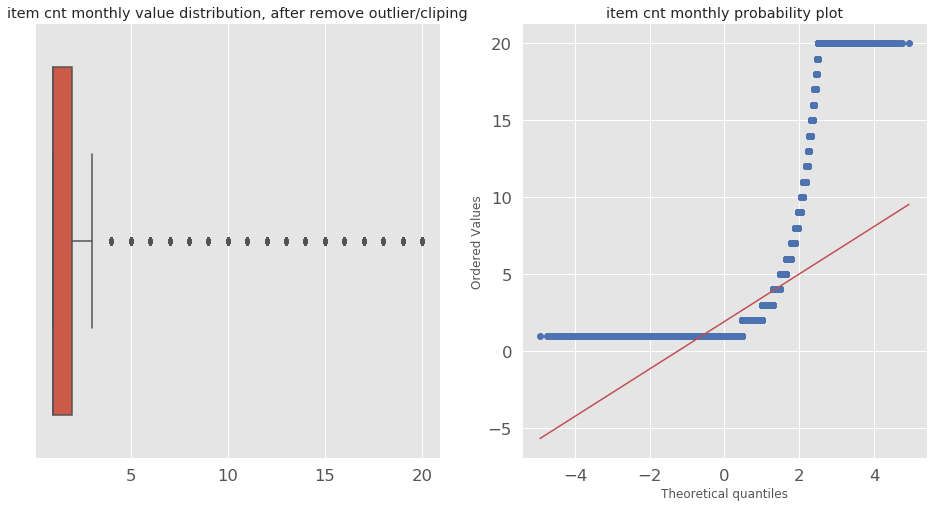

In [31]:
# train_df3.drop(train_df3[train_df3['item_cnt'] > 20].index, inplace=True)
train_df3['item_cnt'] = train_df3['item_cnt'].clip(0,20)
train_df3.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df3['item_cnt'].values, ax=ax[0])
ax[0].set_title('item cnt monthly value distribution, after remove outlier/cliping')
stats.probplot(train_df3['item_cnt'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item cnt monthly probability plot')

Text(0.5, 1.0, 'item price probability plot')

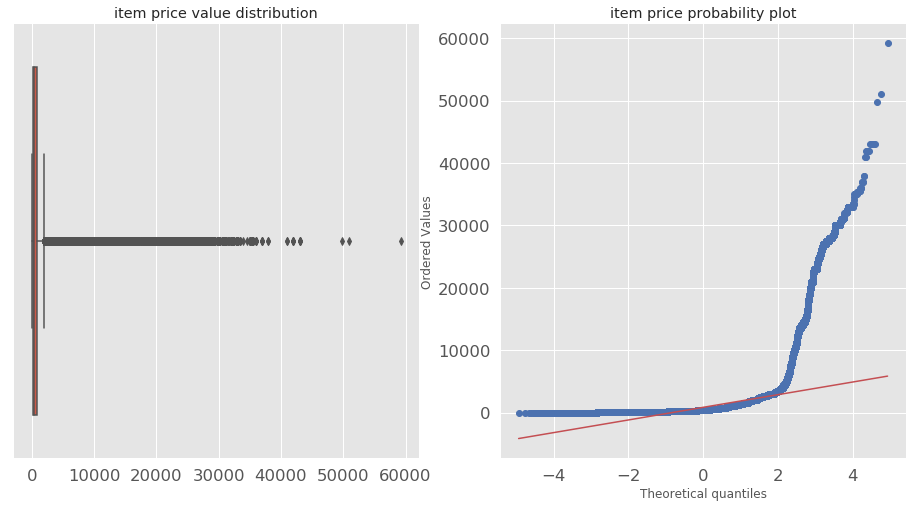

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df3['item_price'].values, ax=ax[0])
ax[0].set_title('item price value distribution')
stats.probplot(train_df3['item_price'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item price probability plot')

* train set과 test set 데이터 구성 비교.

In [33]:
print('train length', 'shop_id', len(set(train_df3['shop_id'])), 
      'item_id', len(set(train_df3['item_id'])), 'item_category_id', len(set(train_df3['item_category_id'])),'\n')

print('test length', 'shop_id', len(set(test_df['shop_id'])), 
      'item_id', len(set(test_df['item_id'])),'item_category_id', len(set(test_df['item_category_id'])),'\n')

train length shop_id 60 item_id 21803 item_category_id 84 

test length shop_id 42 item_id 5100 item_category_id 62 



* test의 item category id, item id 쌍이 train에 포함되어 있는지

In [34]:
test_df[['item_category_id','item_id']].drop_duplicates(['item_category_id', 'item_id'], keep='first')

,item_category_id,item_id
0,19,5037
1,55,5320
2,19,5233
3,23,5232
4,20,5268
...,...,...
5095,55,18454
5096,64,16188
5097,55,15757
5098,40,19648


In [35]:
tmp = train_df3[train_df3['item_category_id'].isin(test_df['item_category_id'].unique())]
tmp = tmp[tmp['item_id'].isin(test_df['item_id'].unique())]
tmp = tmp.drop_duplicates(['item_category_id','item_id'], keep='first')
tmp = tmp.reset_index(drop=True)
print('test len', len(test_df[['item_category_id','item_id']].drop_duplicates(['item_category_id','item_id'], keep='first')), 'temp len', len(tmp))

test len 5100 temp len 4737


* test의 shop id, item id 쌍이 train에 포함되어 있는지

In [36]:
test_df[['shop_id','item_id']].drop_duplicates(['shop_id', 'item_id'], keep='first')

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [37]:
tmp = train_df3[train_df3['shop_id'].isin(test_df['shop_id'].unique())]
tmp = tmp[tmp['item_id'].isin(test_df['item_id'].unique())]
tmp = tmp.drop_duplicates(['shop_id', 'item_id'], keep='first')
tmp = tmp.reset_index(drop=True)
print('test len', len(test_df[['shop_id','item_id']].drop_duplicates(['shop_id', 'item_id'], keep='first')), 'temp len', len(tmp))

test len 214200 temp len 111404


In [38]:
tmp_shop = np.array(sorted(list(set(train_df3[train_df3['shop_id'].isin(test_df['shop_id'].unique())]['shop_id']))))
test_shop = np.array(sorted(test_df['shop_id'].unique()))
print('shop id equal check:', np.array_equal(tmp_shop, test_shop))

tmp_item = np.array(sorted(list(set(train_df3[train_df3['item_id'].isin(test_df['item_id'].unique())]['item_id']))))
test_item = np.array(sorted(test_df['item_id'].unique()))
print('item id equal check:', np.array_equal(tmp_item, test_item))

tmp_item_ca = np.array(sorted(list(set(train_df3[train_df3['item_category_id'].isin(test_df['item_category_id'].unique())]['item_category_id']))))
test_item_ca = np.array(sorted(test_df['item_category_id'].unique()))
print('item category id equal check:', np.array_equal(tmp_item_ca, test_item_ca))

shop id equal check: True
item id equal check: False
item category id equal check: True


## item price

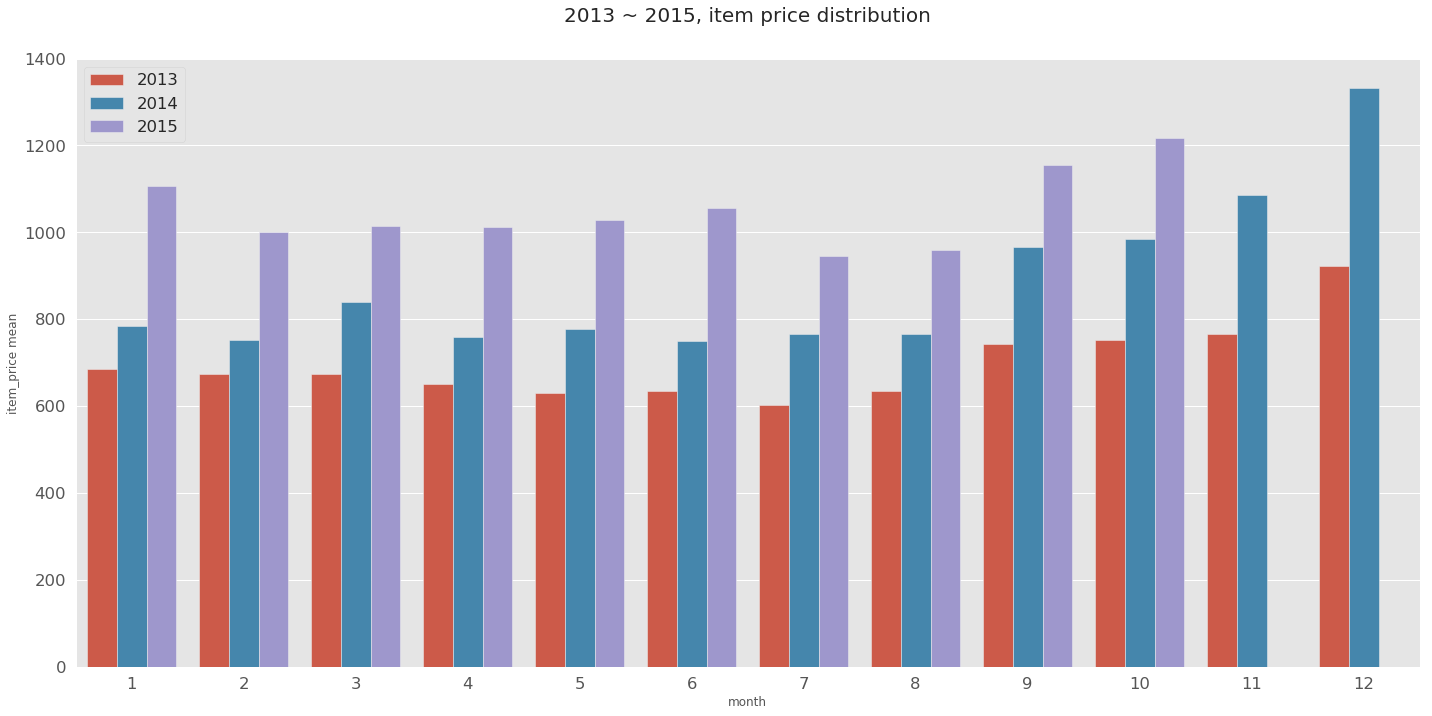

In [39]:
tmp = train_df3.groupby(['year','month'])['item_price'].mean().reset_index()

fig, ax=plt.subplots(1,1,figsize=(20,10))
sns.barplot(x='month', y='item_price', hue='year', data=tmp, ax=ax)
plt.title("2013 ~ 2015, item price distribution", y=1.05, size=20)
plt.xlabel('month')
plt.ylabel('item_price mean')
plt.legend(loc='best')
plt.tight_layout()

* test set에 있는 값들의 분포 확인.

Text(0.5, 1.0, 'G1(shop id/item id) vs G2(shop id/item category id) vs G3(item category id/item id)')

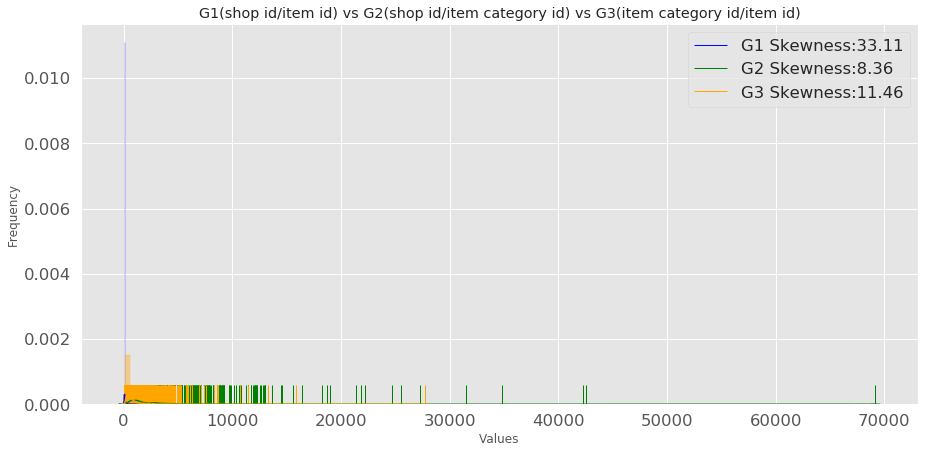

In [40]:
# shop/item, shop/category, category/item
tmp = train_df3[train_df3['shop_id'].isin(test_df['shop_id'].unique())]
tmp = tmp[tmp['item_id'].isin(test_df['item_id'].unique())]
g1_cnt = tmp.groupby(['shop_id', 'item_id'])['item_cnt'].sum().reset_index()

tmp = train_df3[train_df3['shop_id'].isin(test_df['shop_id'].unique())]
tmp = tmp[tmp['item_category_id'].isin(test_df['item_category_id'].unique())]
g2_cnt = tmp.groupby(['shop_id', 'item_category_id'])['item_cnt'].sum().reset_index()

tmp = train_df3[train_df3['item_category_id'].isin(test_df['item_category_id'].unique())]
tmp = tmp[tmp['item_id'].isin(test_df['item_id'].unique())]
g3_cnt = tmp.groupby(['item_category_id', 'item_id'])['item_cnt'].sum().reset_index()

_, ax = plt.subplots(1,1,figsize=(15,7))
sns.distplot(g1_cnt['item_cnt'], color='blue', kde=True, rug=True, ax=ax)
sns.distplot(g2_cnt['item_cnt'], color='green', kde=True, rug=True, ax=ax)
sns.distplot(g3_cnt['item_cnt'], color='orange', kde=True, rug=True, ax=ax)
plt.legend(['G1 Skewness:{:.2f}'.format(g1_cnt['item_cnt'].skew()), 'G2 Skewness:{:.2f}'.format(g2_cnt['item_cnt'].skew()),
           'G3 Skewness:{:.2f}'.format(g3_cnt['item_cnt'].skew())])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('G1(shop id/item id) vs G2(shop id/item category id) vs G3(item category id/item id)')

Text(0.5, 1.0, 'G1(shop id/item id) vs G4(shop id/item category id/item id)')

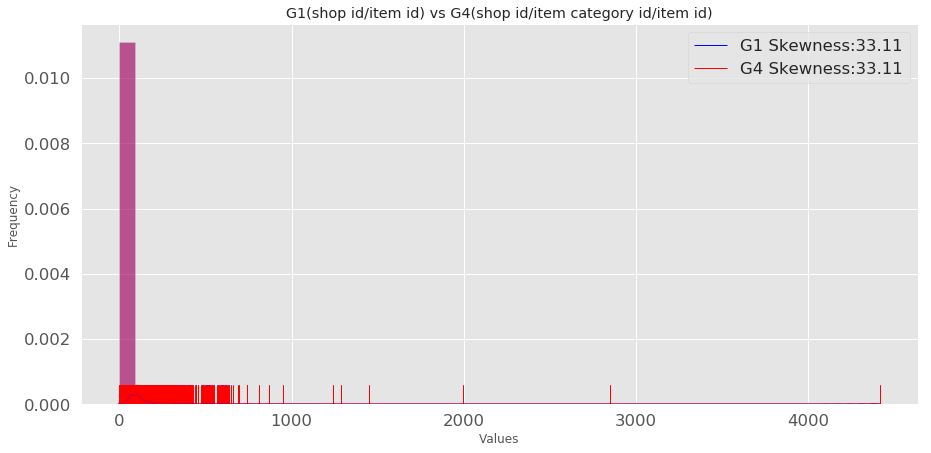

In [41]:
# shop/item, shop/category/item
tmp = train_df3[train_df3['shop_id'].isin(test_df['shop_id'].unique())]
tmp = tmp[tmp['item_category_id'].isin(test_df['item_category_id'].unique())]
tmp = tmp[tmp['item_id'].isin(test_df['item_id'].unique())]
g4_cnt = tmp.groupby(['shop_id','item_category_id', 'item_id'])['item_cnt'].sum().reset_index()

_, ax = plt.subplots(1,1,figsize=(15,7))
sns.distplot(g1_cnt['item_cnt'], color='blue', kde=True, rug=True, ax=ax)
sns.distplot(g4_cnt['item_cnt'], color='red', kde=True, rug=True, ax=ax)
plt.legend(['G1 Skewness:{:.2f}'.format(g1_cnt['item_cnt'].skew()), 'G4 Skewness:{:.2f}'.format(g4_cnt['item_cnt'].skew())])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('G1(shop id/item id) vs G4(shop id/item category id/item id)')

Text(0.5, 1.0, 'groupby(shop id / item id) price distribution')

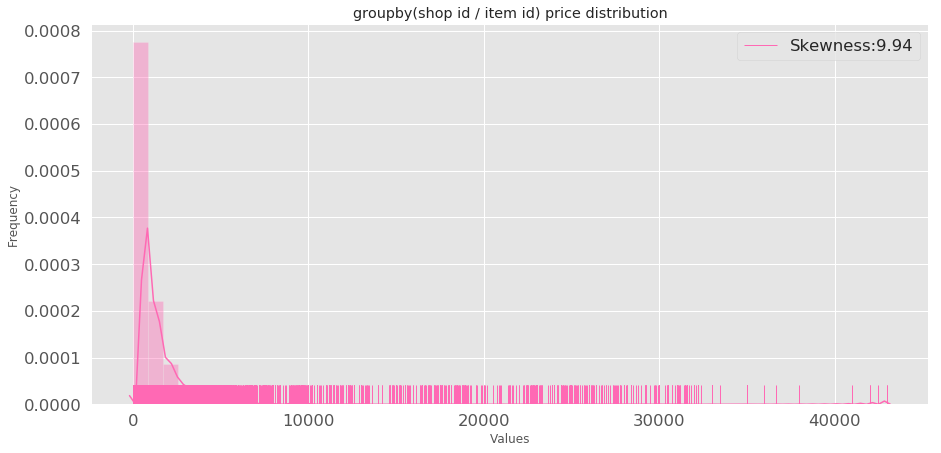

In [42]:
tmp = train_df3[train_df3['shop_id'].isin(test_df['shop_id'].unique())]
tmp = tmp[tmp['item_id'].isin(test_df['item_id'].unique())]
price_mean_g1 = tmp.groupby(['shop_id', 'item_id'])['item_price'].mean().reset_index()

_, ax = plt.subplots(1,1,figsize=(15,7))
sns.distplot(price_mean_g1['item_price'], color='hotpink', kde=True, rug=True, ax=ax)
plt.legend(['Skewness:{:.2f}'.format(price_mean_g1['item_price'].skew())])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('groupby(shop id / item id) price distribution')

In [43]:
train_df3 = train_df3[['year', 'month', 'date_block_num', 'shop_id', 'item_category_id', 'item_id','item_price','item_cnt']]
train_df3.head()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt
0,2013,2,1,0,0,16255,93.0,1.0
1,2013,2,1,0,1,5740,283.0,1.0
2,2013,2,1,0,2,5570,93.0,1.0
3,2013,1,0,0,2,5572,1322.0,10.0
4,2013,2,1,0,2,5572,1322.0,11.0


# EDA

* **correlation plot**
> time and sales, shop and sales, item category and sales, price and sales,..

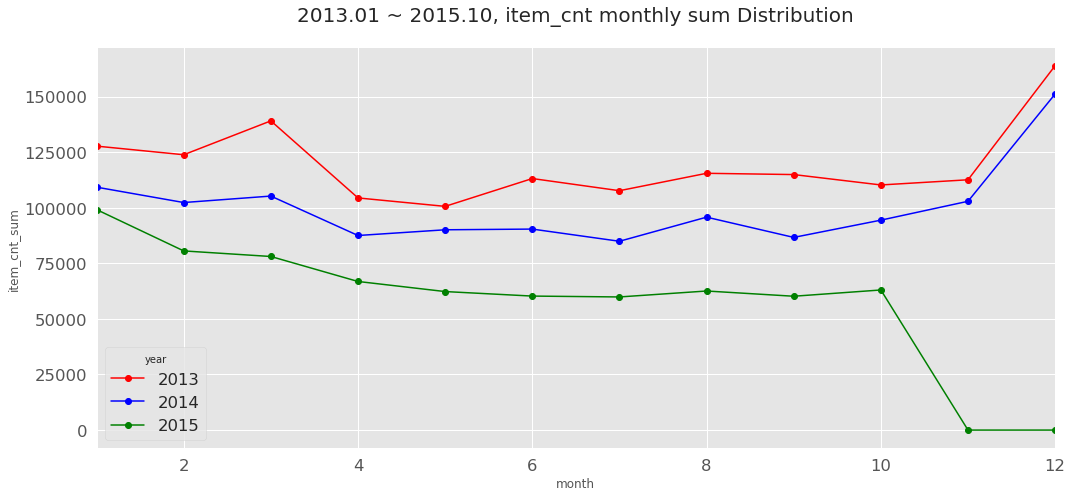

In [44]:
# 연도별
ym_train_df = train_df3.groupby(['year','month'])['item_cnt'].sum().unstack()
ym_train_df.fillna(0, inplace=True)

fig, ax=plt.subplots(1,1,figsize=(15,7))
ym_train_df.T.plot(marker='o', c='k', color=['red','blue','green'], ax=ax)
plt.title("2013.01 ~ 2015.10, item_cnt monthly sum Distribution", y=1.05, size=20)
plt.xlabel('month')
plt.ylabel('item_cnt_sum')
plt.tight_layout()

In [45]:
# fig, ax=plt.subplots(1,1,figsize=(30,10))
# sns.stripplot(x='month', y="item_cnt", hue='year', data=train_df3, ax=ax)
# ax.set_title("2013.01 ~ 2015.10, item_cnt monthly sum Distribution", y=1.05, size=20)
# plt.legend(loc='best')

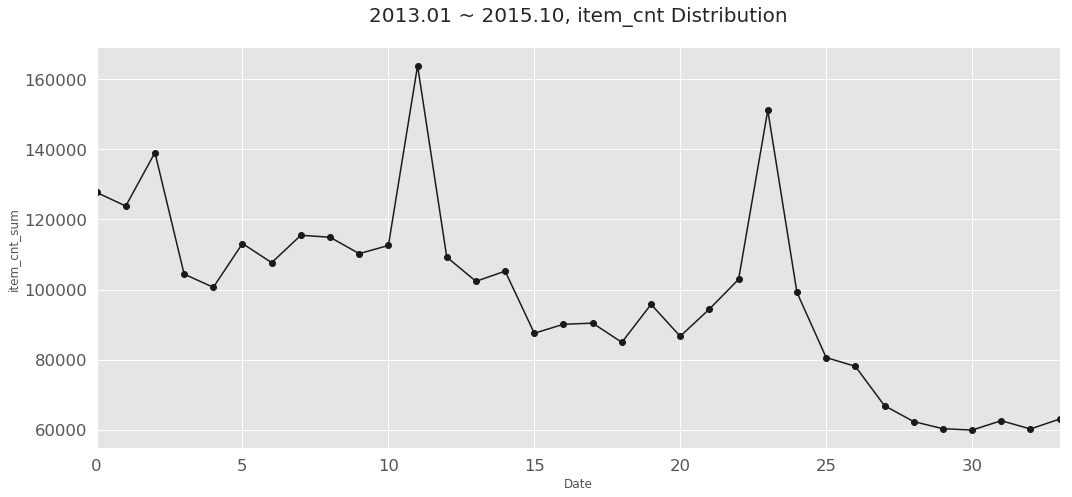

In [46]:
fig, ax=plt.subplots(1,1,figsize=(15,7))
train_df3.groupby('date_block_num')['item_cnt'].sum().plot(marker='o',c='k',ax=ax)
plt.title("2013.01 ~ 2015.10, item_cnt Distribution", y=1.05, size=20)
plt.xlabel('Date')
plt.ylabel('item_cnt_sum')
plt.tight_layout()

In [47]:
# 2013
df2013 = train_df3.loc[train_df3['year']==2013]
df2013.reset_index(drop=True, inplace=True)
df2013g = df2013.groupby(['year','month'])['item_cnt'].sum().unstack()
df2013g.fillna(0, inplace=True)
# 2014
df2014 = train_df3.loc[train_df3['year']==2014]
df2014.reset_index(drop=True, inplace=True)
df2014g = df2014.groupby(['year','month'])['item_cnt'].sum().unstack()
df2014g.fillna(0, inplace=True)
# 2015
df2015 = train_df3.loc[train_df3['year']==2015]
df2015.reset_index(drop=True, inplace=True)
df2015g = df2015.groupby(['year','month'])['item_cnt'].sum().unstack()
df2015g.fillna(0, inplace=True)

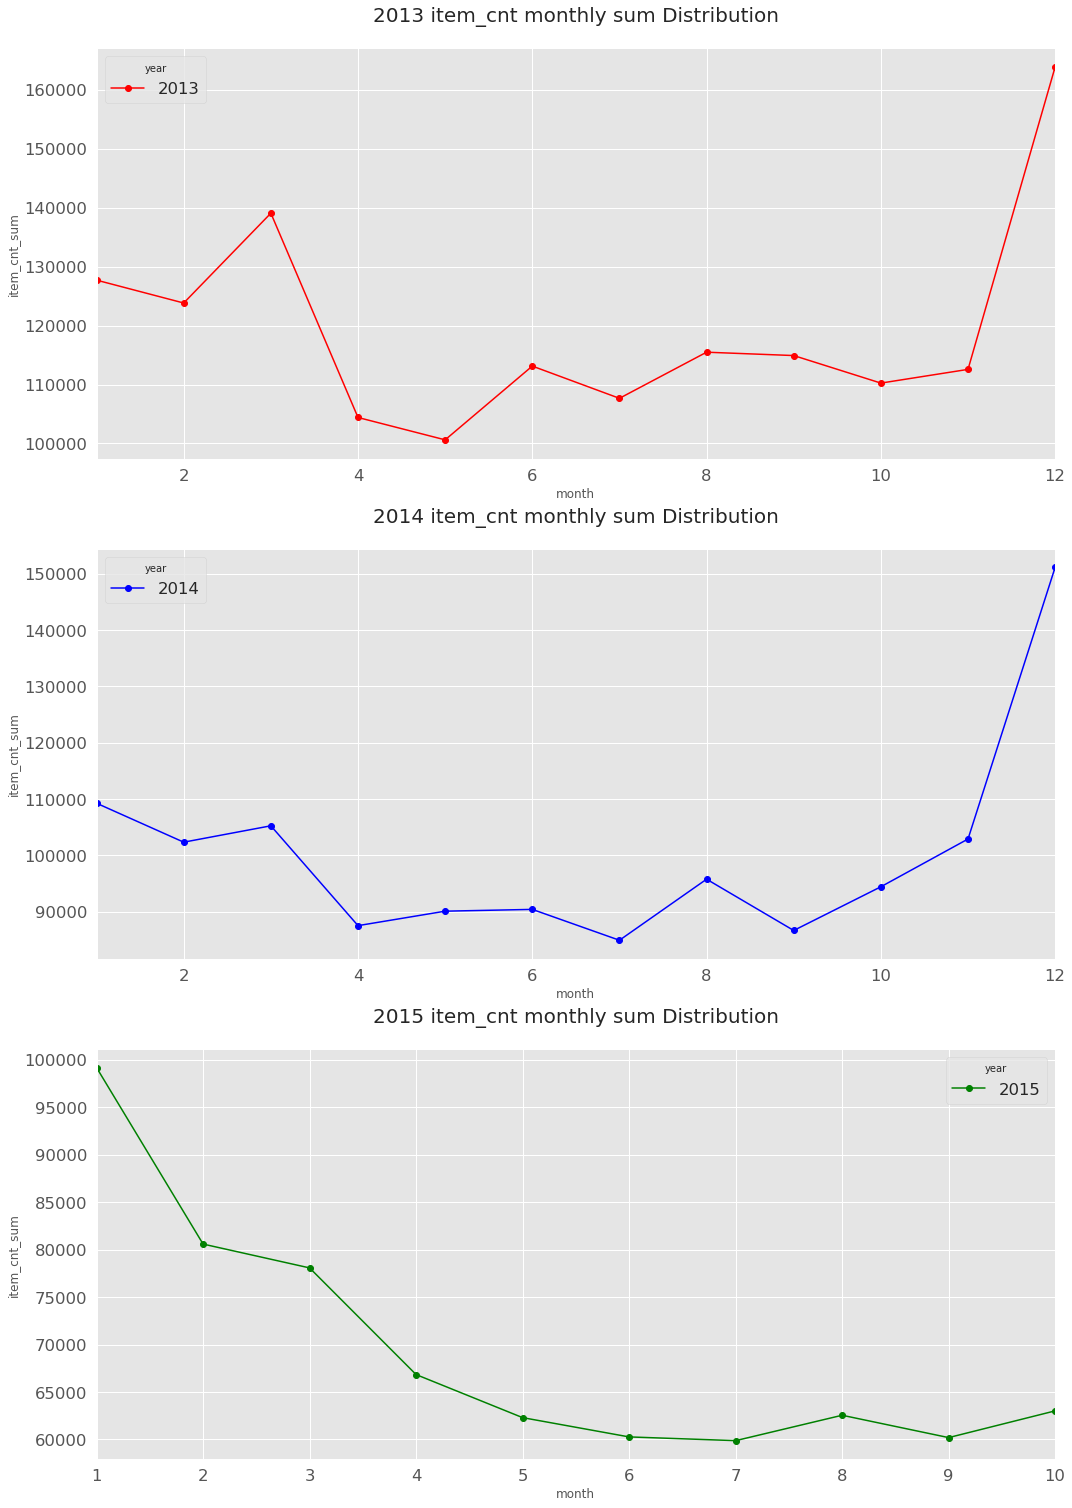

In [48]:
color=['red','blue','green']
fig, ax=plt.subplots(3,1,figsize=(15,21))
df2013g.T.plot(marker='o', c='k', color=color[0], ax=ax[0])
ax[0].set_title("2013 item_cnt monthly sum Distribution", y=1.05, size=20)
ax[0].set_xlabel('month')
ax[0].set_ylabel('item_cnt_sum')
df2014g.T.plot(marker='o', c='k', color=color[1], ax=ax[1])
ax[1].set_title("2014 item_cnt monthly sum Distribution", y=1.05, size=20)
ax[1].set_xlabel('month')
ax[1].set_ylabel('item_cnt_sum')
df2015g.T.plot(marker='o', c='k', color=color[2], ax=ax[2])
ax[2].set_title("2015 item_cnt monthly sum Distribution", y=1.05, size=20)
ax[2].set_xlabel('month')
ax[2].set_ylabel('item_cnt_sum')

plt.tight_layout()

In [49]:
# color=['red','blue','green']
# fig, ax=plt.subplots(3,1,figsize=(15,21))
# sns.boxplot(x='month', y="item_cnt", data=train_df3.loc[train_df3['year']==2013], ax=ax[0])
# ax[0].set_title("2013 item_cnt monthly sum Distribution", y=1.05, size=20)
# ax[0].set_xlabel('month')
# ax[0].set_ylabel('item_cnt_sum')
# sns.boxplot(x='month', y="item_cnt", data=train_df3.loc[train_df3['year']==2014], ax=ax[1])
# ax[1].set_title("2014 item_cnt monthly sum Distribution", y=1.05, size=20)
# ax[1].set_xlabel('month')
# ax[1].set_ylabel('item_cnt_sum')
# sns.boxplot(x='month', y="item_cnt", data=train_df3.loc[train_df3['year']==2015], ax=ax[2])
# ax[2].set_title("2015 item_cnt monthly sum Distribution", y=1.05, size=20)
# ax[2].set_xlabel('month')
# ax[2].set_ylabel('item_cnt_sum')

# plt.tight_layout()

Text(0.5, 1.0, "shop's item cnt distribution(year)")

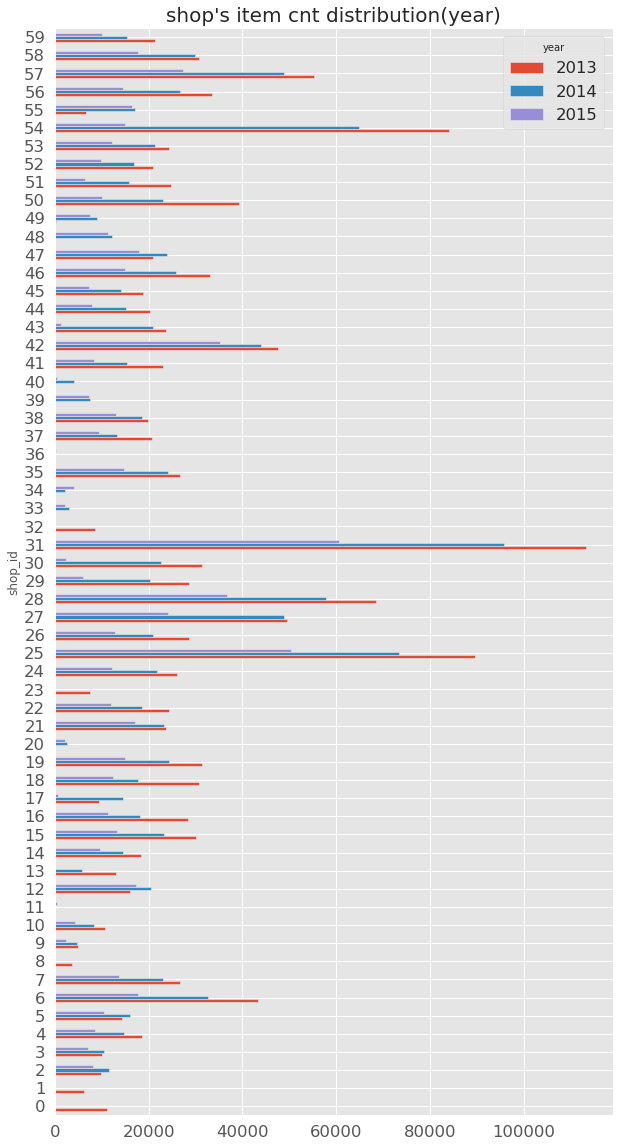

In [50]:
sdf = pd.DataFrame(train_df3.groupby(['shop_id','year'])['item_cnt'].sum())
sdf.reset_index(inplace=True)

_, ax = plt.subplots(1,1,figsize=(10,20))
train_df3.groupby(['shop_id','year'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax)
ax.set_title("shop's item cnt distribution(year)", size=20)

Text(0.5, 1.0, "shop's item cnt distribution(month)")

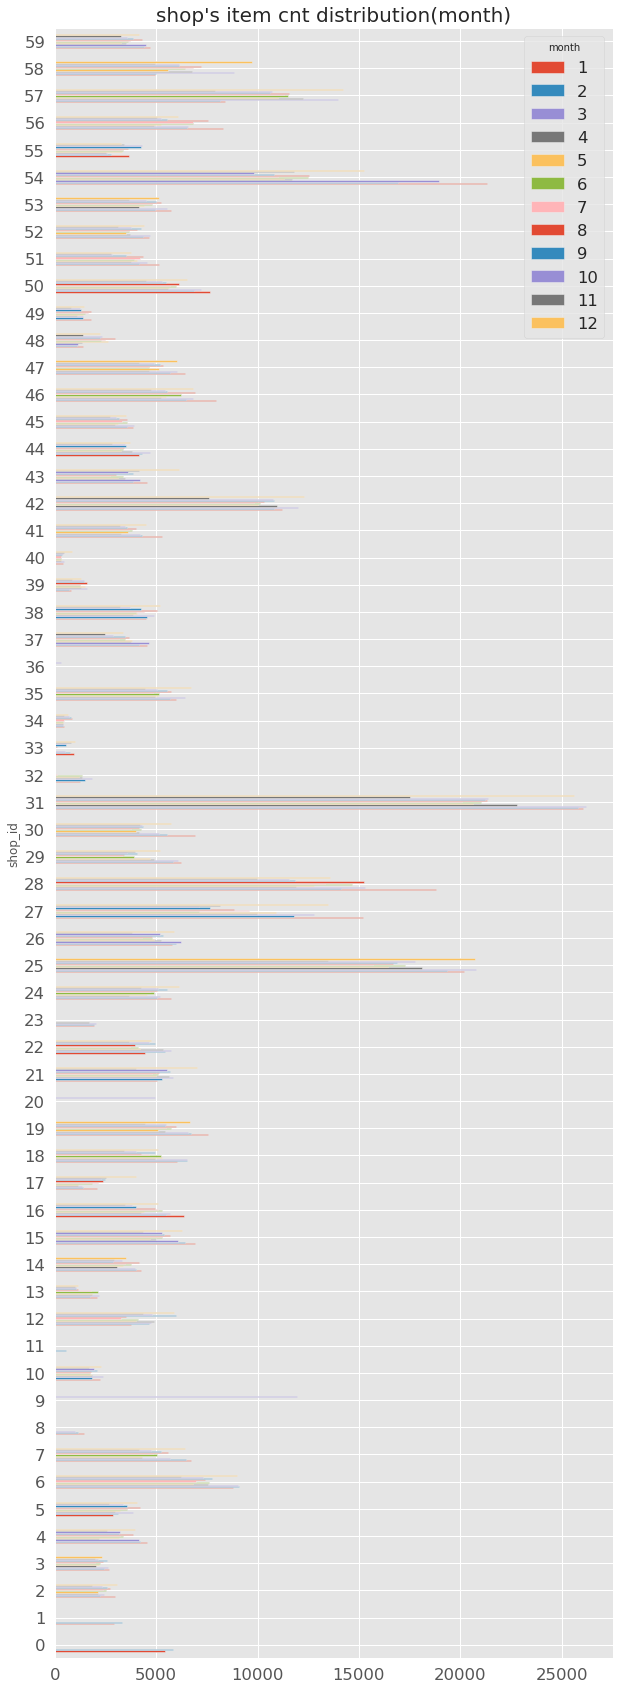

In [51]:
_, ax = plt.subplots(1,1,figsize=(10,30))
train_df3.groupby(['shop_id','month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax)
ax.set_title("shop's item cnt distribution(month)", size=20)

Text(0.5, 1.0, '2015')

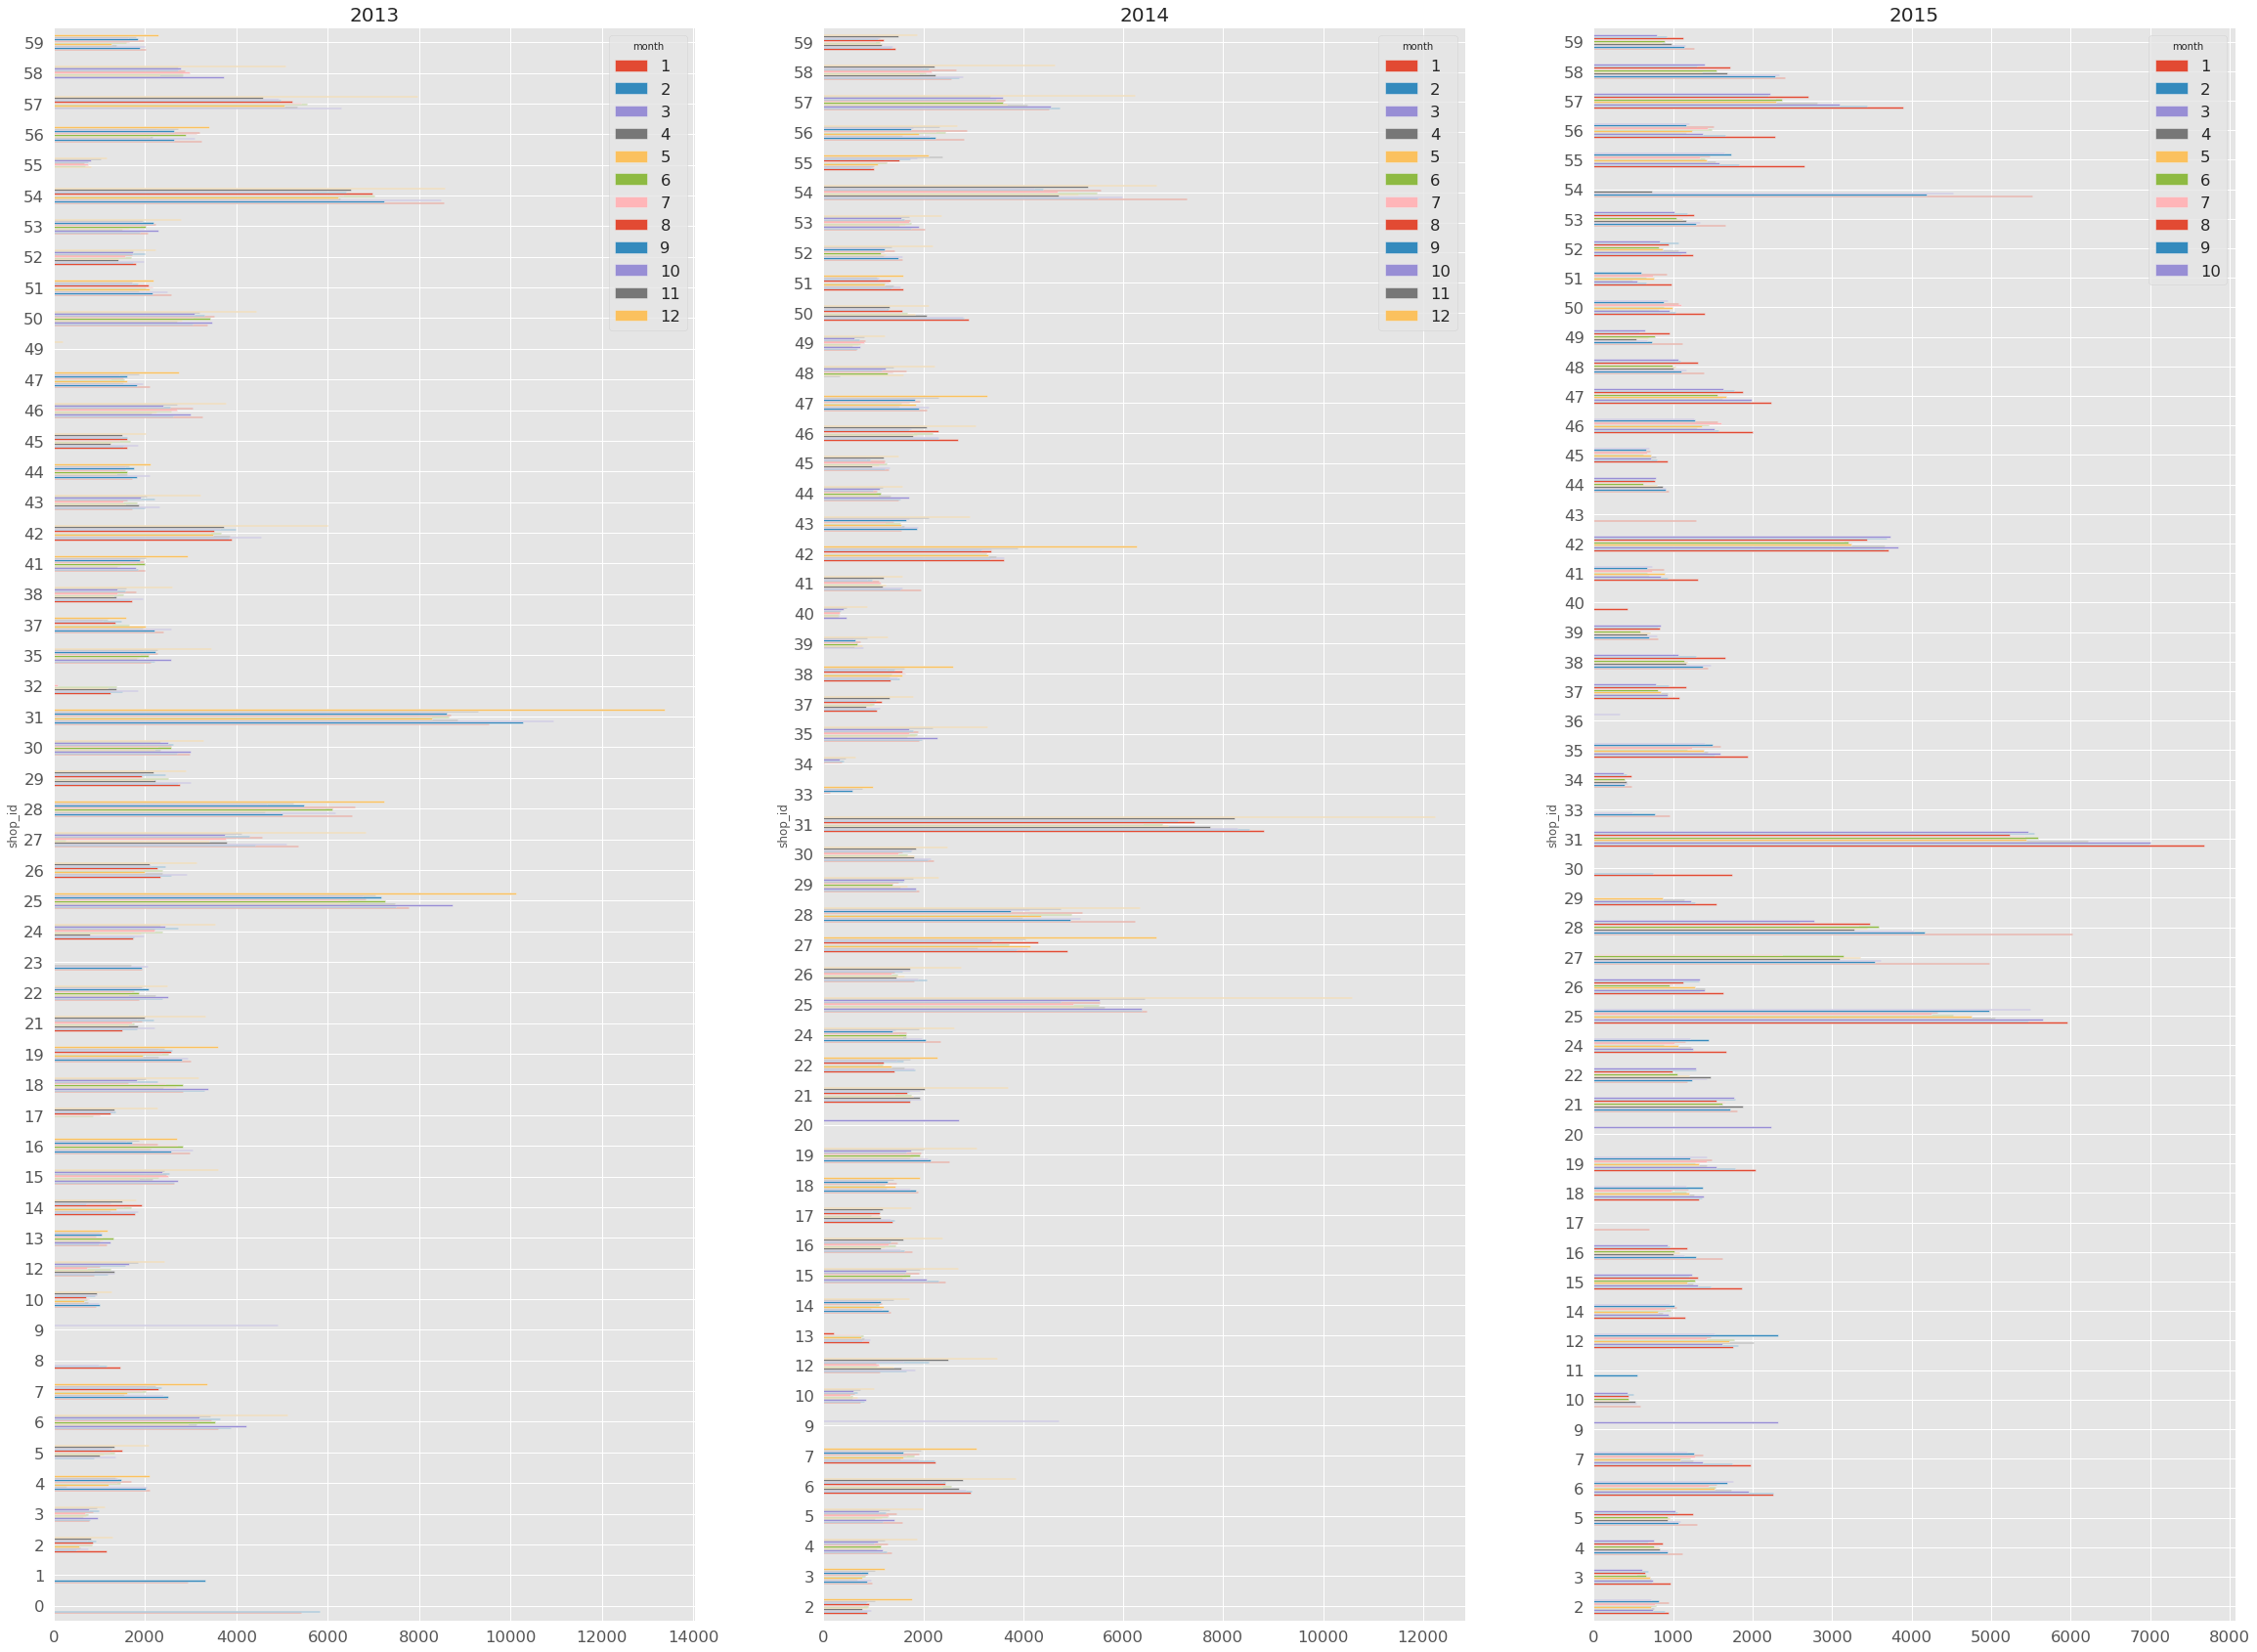

In [52]:
# 2013
_, ax = plt.subplots(1,3,figsize=(40,30))
df2013g = df2013.groupby(['shop_id','month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[0])
ax[0].set_title("2013", size=20)

# 2014
df2014g = df2014.groupby(['shop_id','month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[1])
ax[1].set_title("2014", size=20)

# 2015
df2015g = df2015.groupby(['shop_id','month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[2])
ax[2].set_title("2015", size=20)

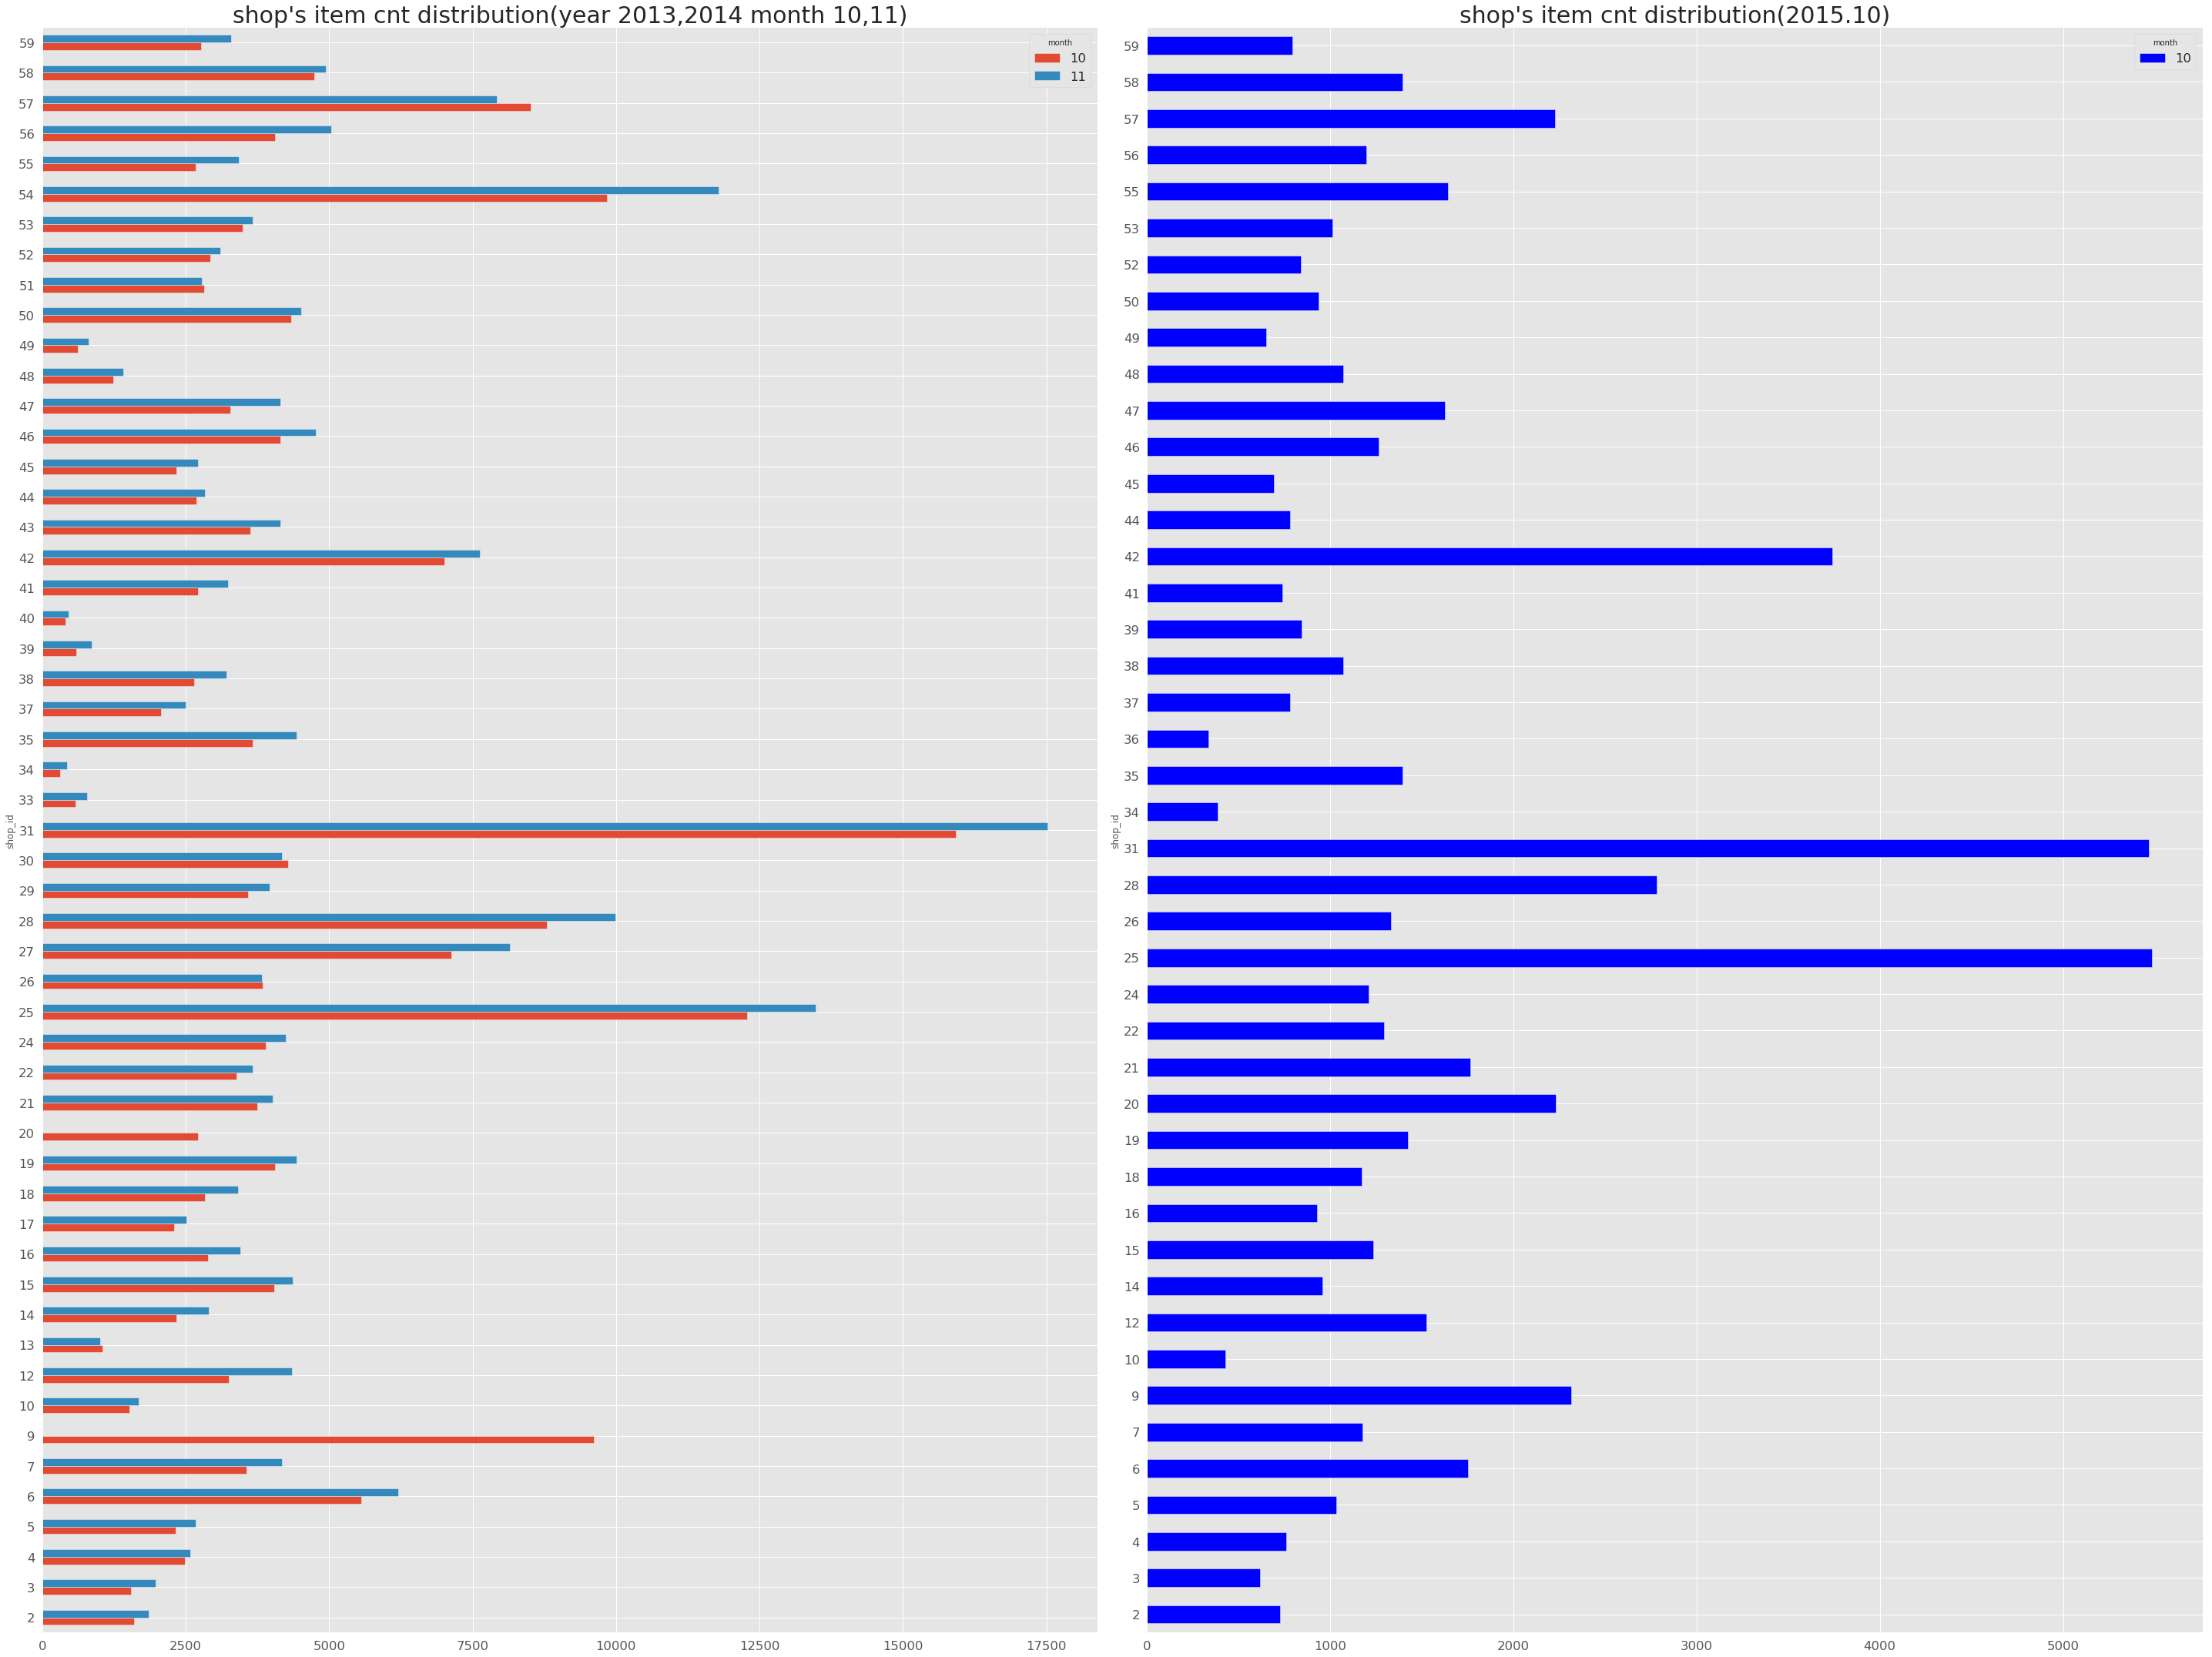

In [53]:
_, ax = plt.subplots(1,2,figsize=(40,30))
tmp = train_df3.loc[(train_df3['month']==10) | (train_df3['month']==11)]
tmp = tmp.loc[(tmp['year']==2013) | (tmp['year']==2014)]
tmp.groupby(['shop_id','month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[0])
ax[0].set_title("shop's item cnt distribution(year 2013,2014 month 10,11)", size=30)
# length = int(max(tmp.groupby(['shop_id','month'])['item_cnt'].sum()))

tmp = train_df3.loc[(train_df3['month']==10) & (train_df3['year']==2015)]
tmp.groupby(['shop_id','month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[1], color='blue')
ax[1].set_title("shop's item cnt distribution(2015.10)", size=30)
# ax[1].set_xticks(range(length))

plt.tight_layout()

Text(0.5, 1.0, 'category item cnt distribution')

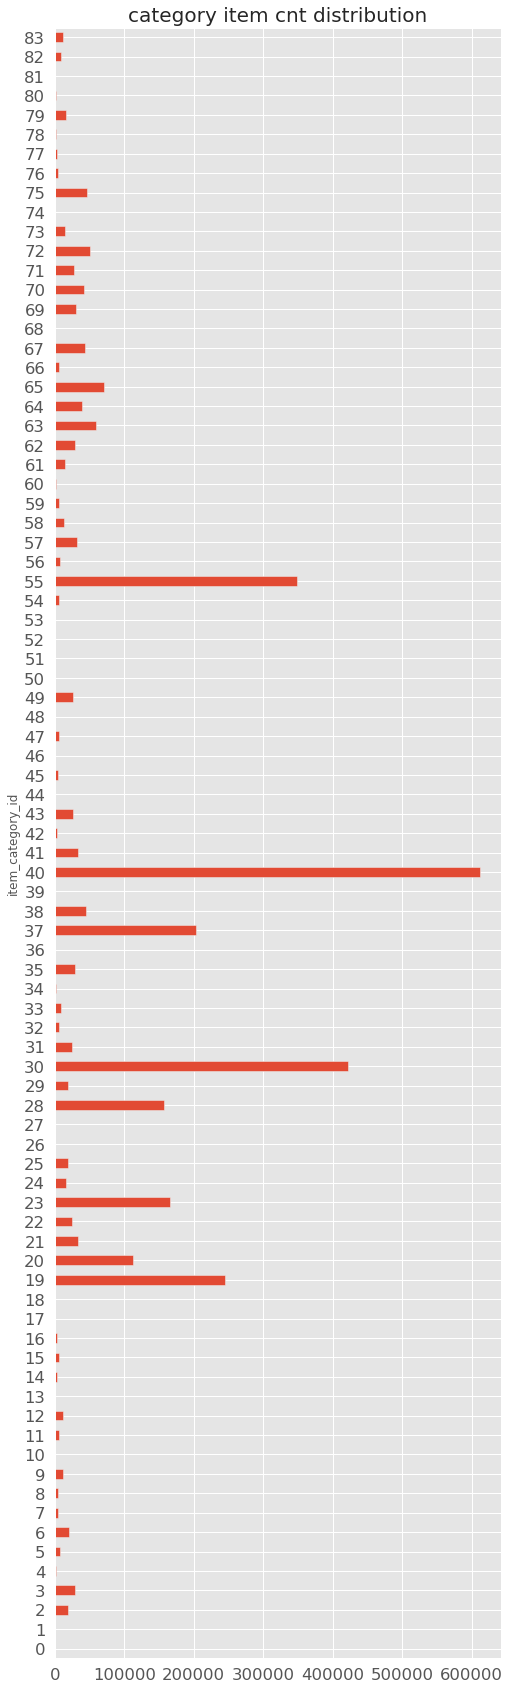

In [54]:
_, ax = plt.subplots(1,1,figsize=(8,30))
train_df3.groupby('item_category_id')['item_cnt'].sum().plot(kind='barh', ax=ax)
ax.set_title('category item cnt distribution', size=20)

In [55]:
# _, ax = plt.subplots(1,1,figsize=(40,16))
# train_df3.groupby(['item_category_id', 'month'])['item_cnt'].sum().unstack().plot(kind='bar', ax=ax)
# ax.set_title('category item cnt distribution(month)', y=1.05, size=40)

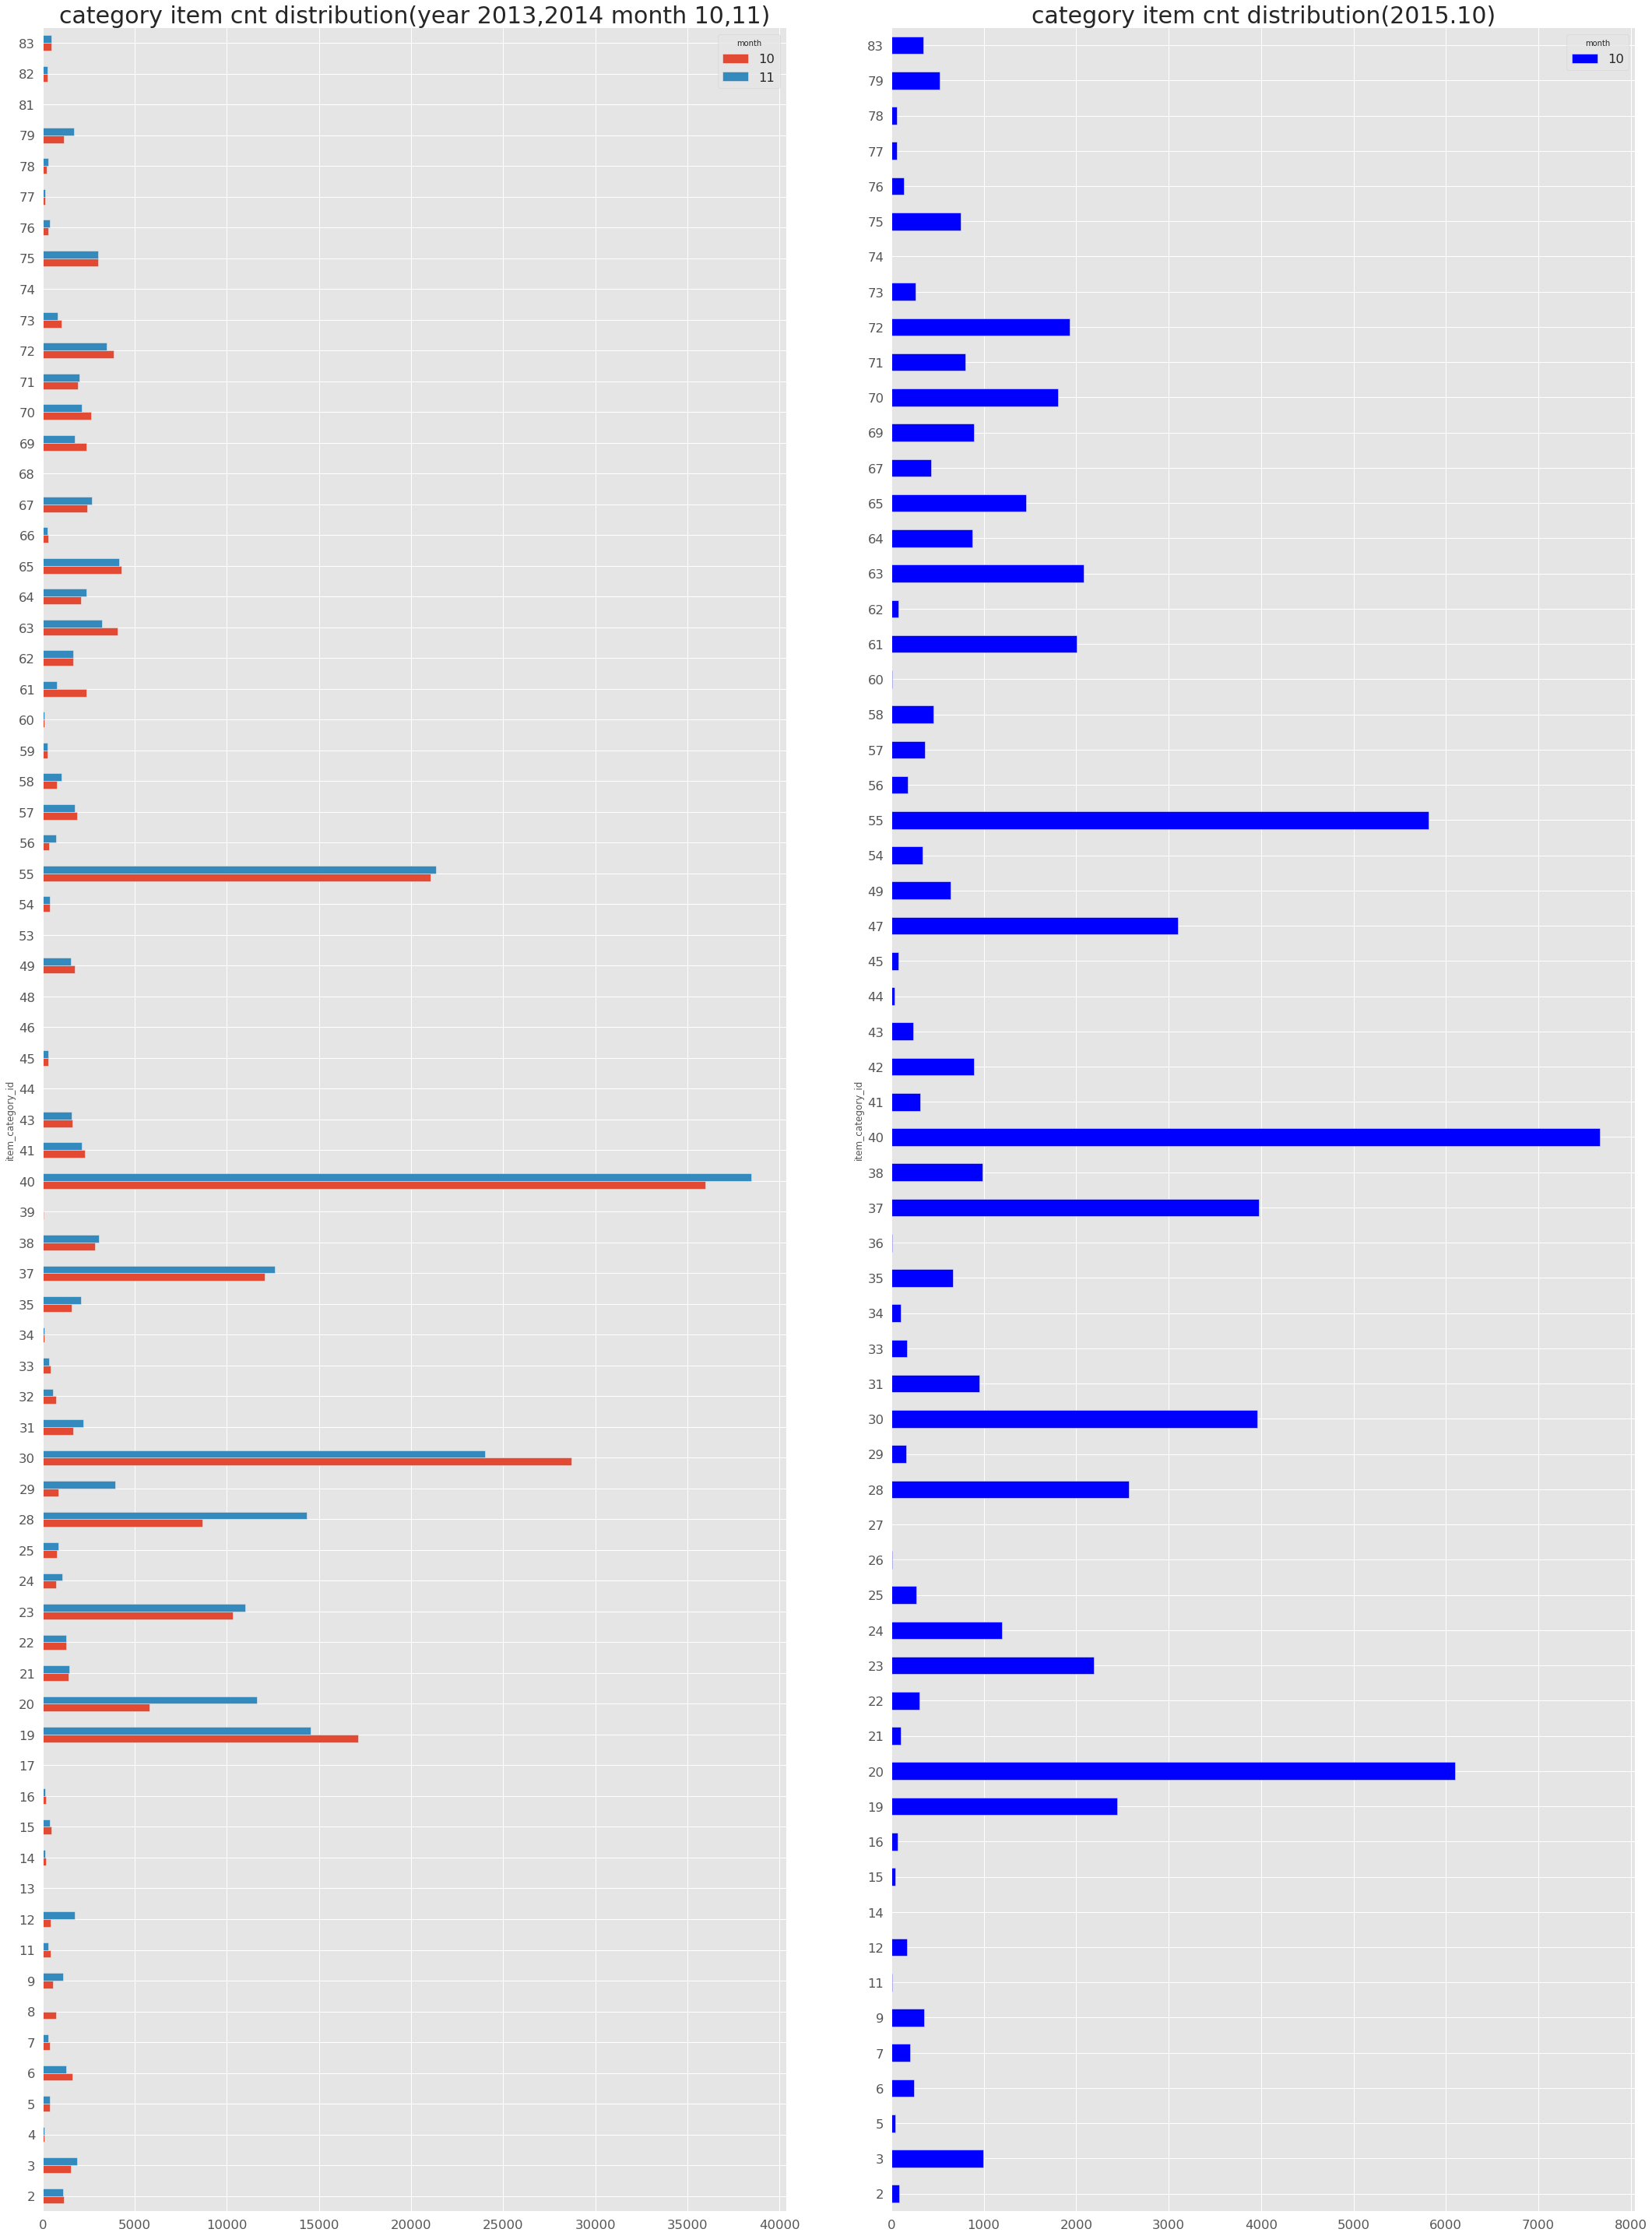

In [56]:
_, ax = plt.subplots(1,2,figsize=(30,40))
tmp = train_df3.loc[(train_df3['month']==10) | (train_df3['month']==11)]
tmp = tmp.loc[(tmp['year']==2013) | (tmp['year']==2014)]
tmp.groupby(['item_category_id', 'month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[0])
ax[0].set_title('category item cnt distribution(year 2013,2014 month 10,11)', size=30)

tmp = train_df3.loc[(train_df3['month']==10) & (train_df3['year']==2015)]
tmp.groupby(['item_category_id', 'month'])['item_cnt'].sum().unstack().plot(kind='barh', ax=ax[1], color='blue')
ax[1].set_title('category item cnt distribution(2015.10)', size=30)
plt.tight_layout()

Text(0.5, 1.05, 'price/item cnt plot')

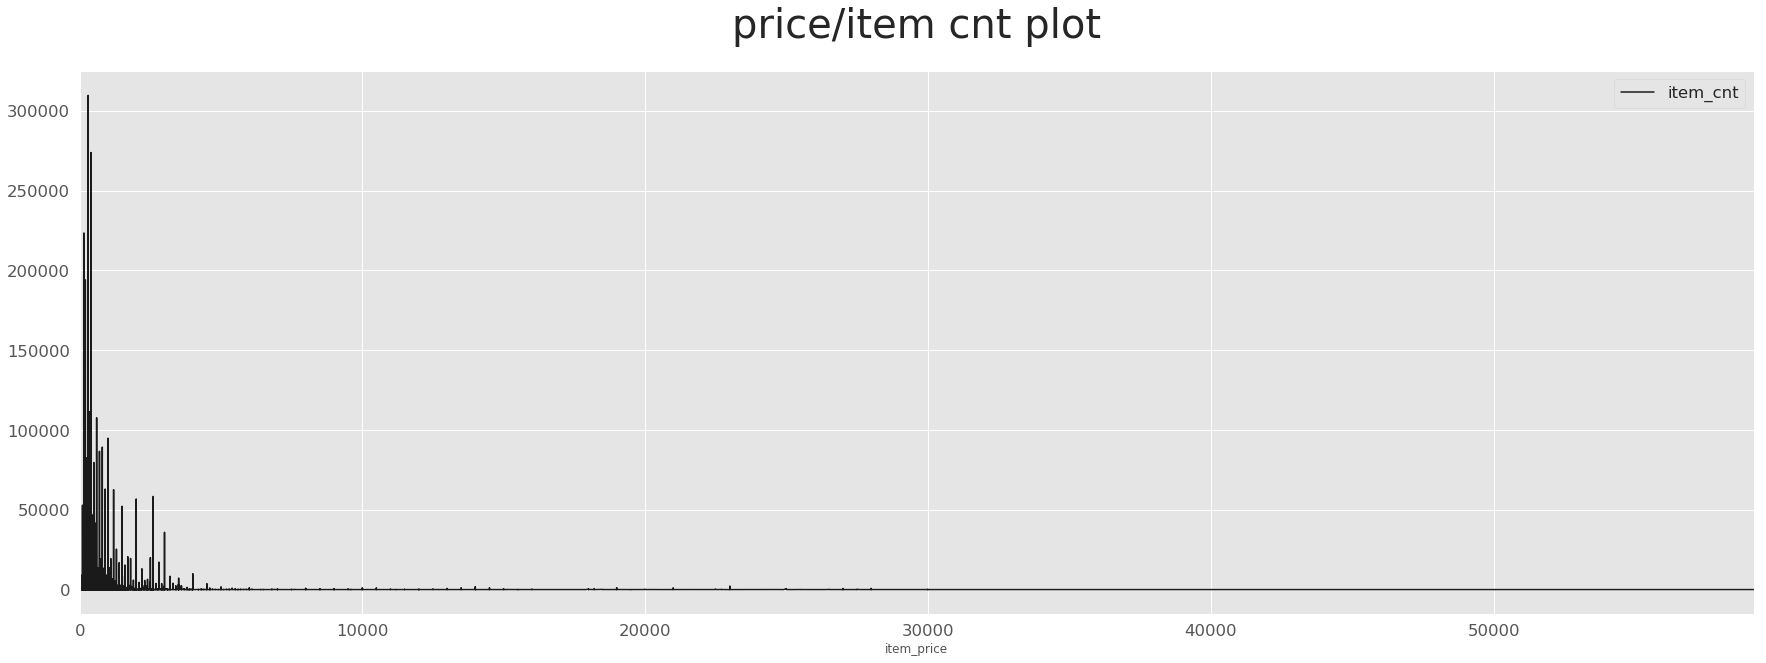

In [57]:
_, ax = plt.subplots(1,1,figsize=(30,10))
tmp = pd.DataFrame(train_df3.groupby('item_price')['item_cnt'].sum())
tmp.plot(c='k', ax=ax)
ax.set_title('price/item cnt plot', y=1.05, size=40)

Text(0, 0.5, 'item cnt')

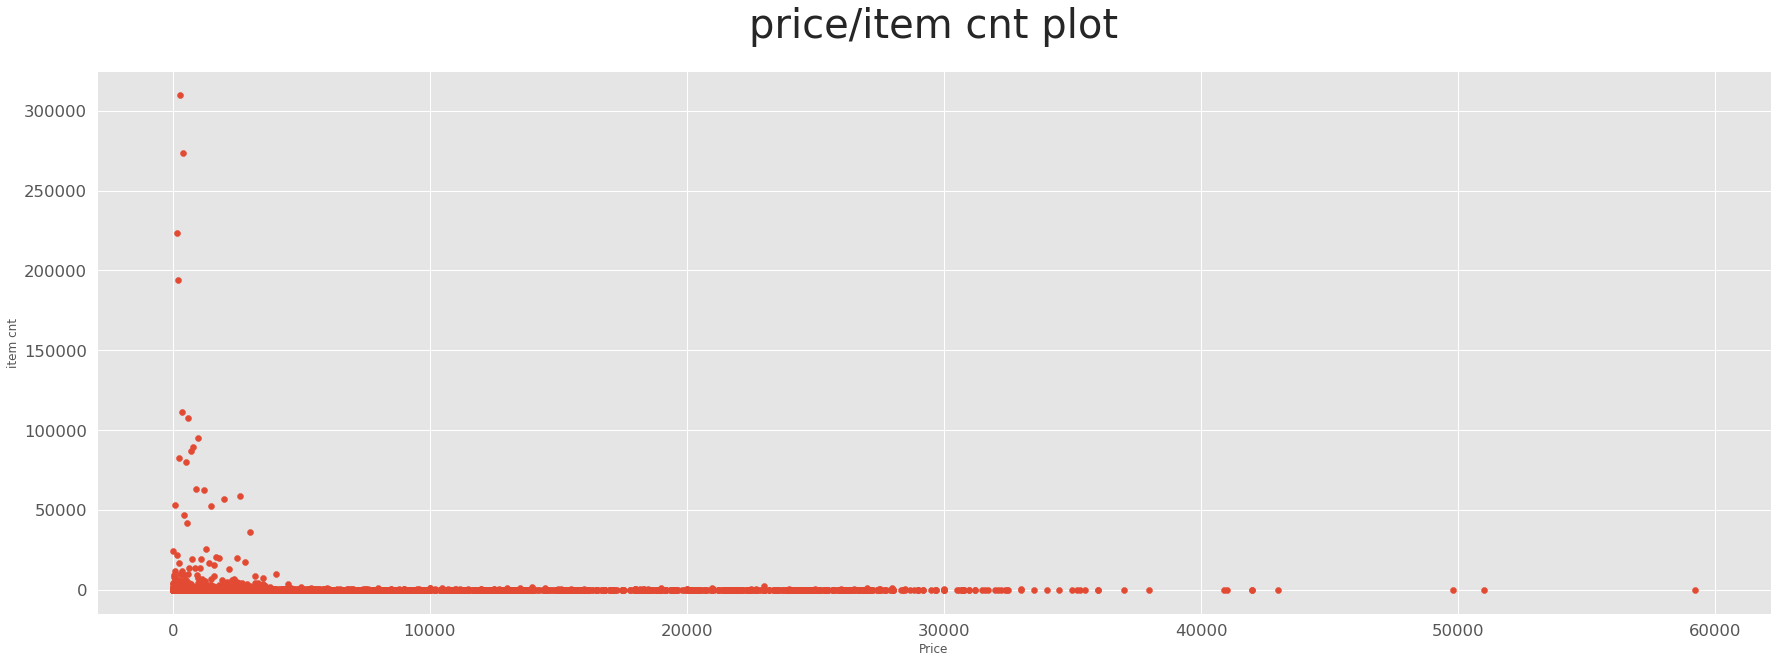

In [58]:
_, ax = plt.subplots(1,1,figsize=(30,10))
tmp.reset_index(inplace=True)
ax.scatter(tmp['item_price'], tmp['item_cnt'])
ax.set_title('price/item cnt plot', y=1.05, size=40)
ax.set_xlabel('Price')
ax.set_ylabel('item cnt')

Text(0, 0.5, 'item cnt')

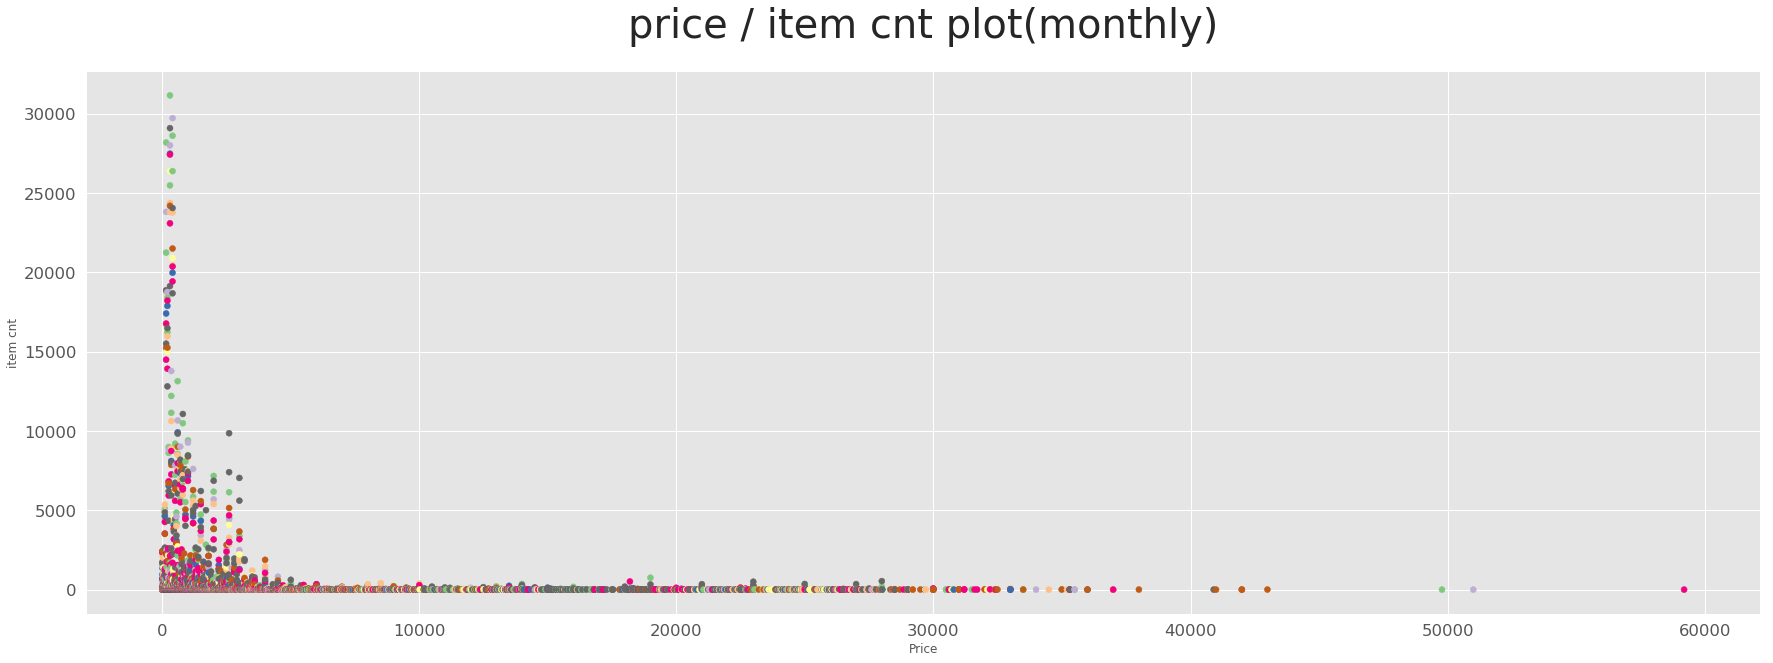

In [59]:
_, ax = plt.subplots(1,1,figsize=(30,10))
tmp = pd.DataFrame(train_df3.groupby(['item_price','month'])['item_cnt'].sum())
tmp.reset_index(inplace=True)
ax.scatter(tmp['item_price'], tmp['item_cnt'], c=tmp['month'], cmap=plt.cm.Accent)
ax.set_title('price / item cnt plot(monthly)', y=1.05, size=40)
ax.set_xlabel('Price')
ax.set_ylabel('item cnt')

* **correlation map**
> https://github.com/shakedzy/dython/issues/2

In [60]:
!pip install dython

In [61]:
from dython import nominal

In [62]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737862 entries, 0 to 1737861
Data columns (total 8 columns):
year                int64
month               int64
date_block_num      int64
shop_id             int64
item_category_id    int64
item_id             int64
item_price          float64
item_cnt            float64
dtypes: float64(2), int64(6)
memory usage: 106.1 MB


Text(0.5, 1.05, 'features correlation map')

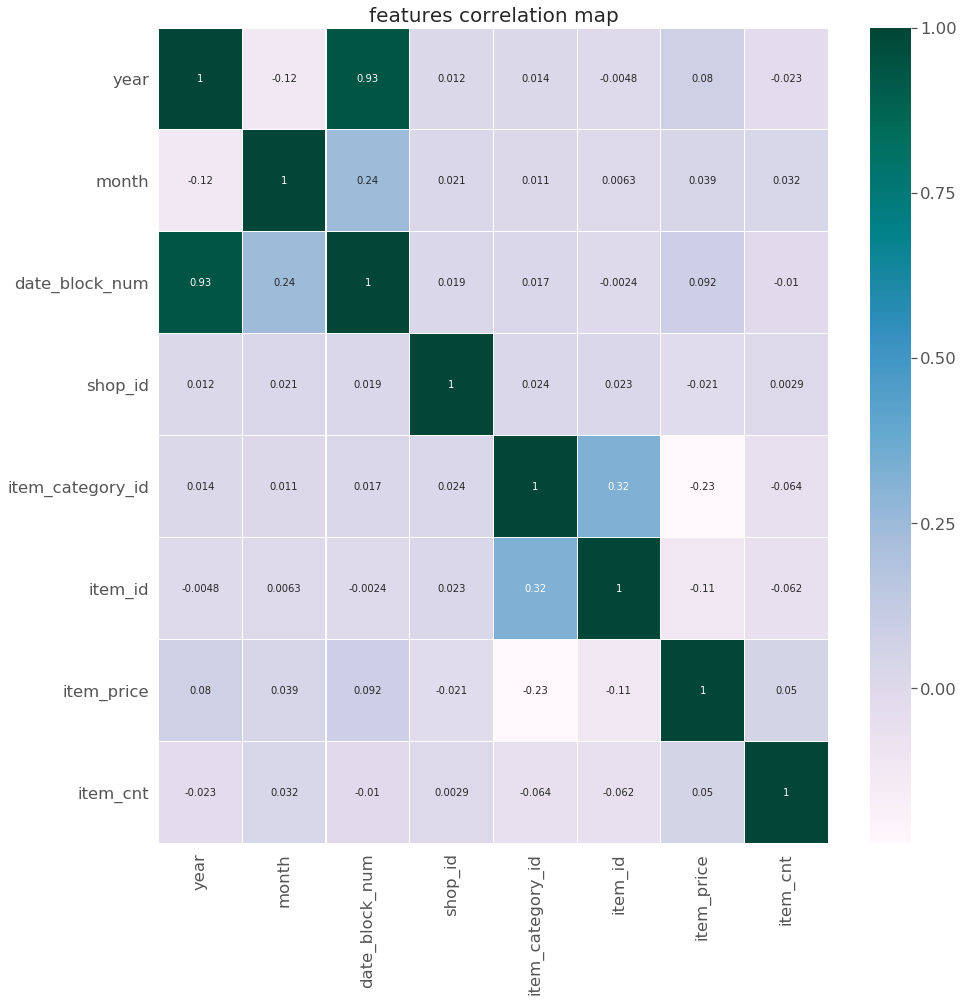

In [63]:
_, ax = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(train_df3.astype('float').corr(), linewidths=0.1,vmax=1.0, cmap=plt.cm.PuBuGn, linecolor='white', annot=True, ax=ax)
ax.set_title('features correlation map', y=1.05, size=20)

In [64]:
train_df3['shop_id'] = train_df3['shop_id'].astype(str)
train_df3['item_id'] = train_df3['item_id'].astype(str)
train_df3['item_category_id'] = train_df3['item_category_id'].astype(str)

Text(0.5, 1.05, 'features correlation map')

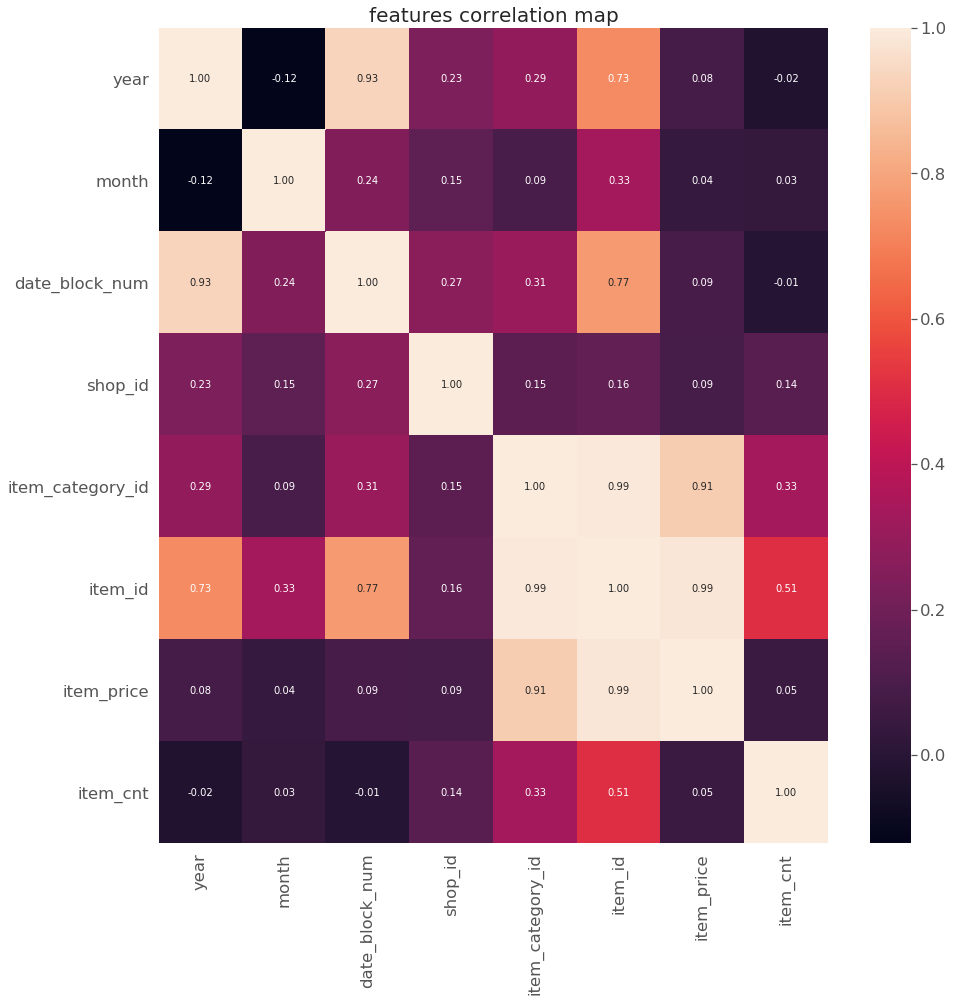

In [65]:
_, ax = plt.subplots(1,1,figsize=(15,15))
nominal.associations(train_df3, nominal_columns=['shop_id','item_id','item_category_id'], ax=ax)
ax.set_title('features correlation map', y=1.05, size=20)

Text(0.5, 1.05, 'continuous features correlation map')

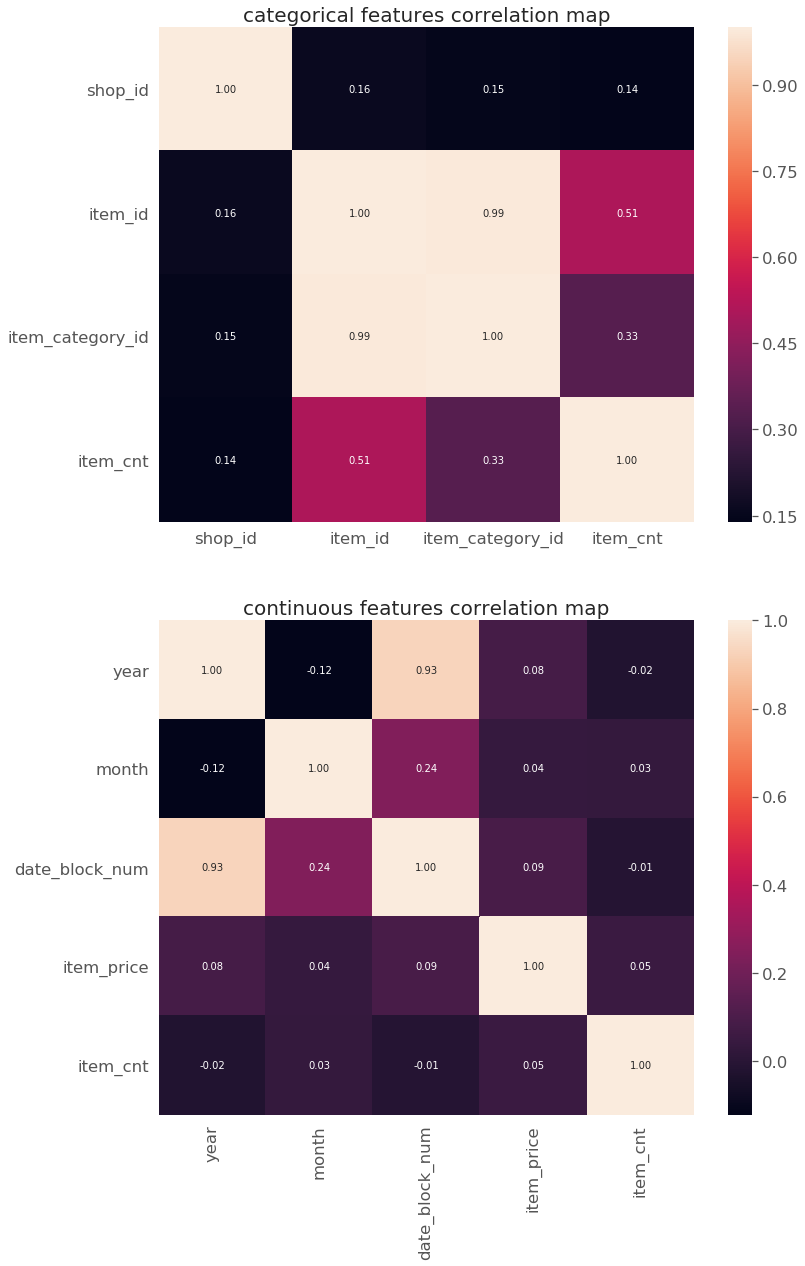

In [66]:
_, ax = plt.subplots(2,1,figsize=(12,20))
nominal.associations(train_df3[['shop_id','item_id','item_category_id','item_cnt']], nominal_columns=['shop_id','item_id','item_category_id'], ax=ax[0])
ax[0].set_title('categorical features correlation map', y=1.05, size=20)

nominal.associations(train_df3[['year','month','date_block_num','item_price','item_cnt']], ax=ax[1])
ax[1].set_title('continuous features correlation map', y=1.05, size=20)